# Data Analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# Disable interactive mode.
# https://stackoverflow.com/questions/15713279/calling-pylab-savefig-without-display-in-ipython
# plt.ioff()

from time import perf_counter

from pathlib import Path
pathtohere = Path()

In [2]:
from pyDataAnalysis.readData import *

from pyDataAnalysis.photon import Photon
from pyDataAnalysis.Zboson import Zboson
from pyDataAnalysis.Worders.Wboson_LO import Wboson_LO
from pyDataAnalysis.Worders.Wboson_NLO import Wboson_NLO

In [3]:
def display_PDFs(xs:np.ndarray, data:np.ndarray, headings:tuple,colours:tuple,q:float, momFrac:int):
    """
    Display the PDFs.
    
    Inputs:
        - xs:np.ndarray: Momentum fractions the PDFs are evaluated at.
        - data:np.ndarray: 2D array of PDFs of each used quark at all x.
        - headings:tuple: Quark types used.
        - colours:tuple: Graph colours.
        - q:float: Q evaluated at.
        - momFrac:int: Momentum fraction index 1/2.
    """
    
    fig = plt.figure(figsize=(6,6), dpi=250)
    ax = fig.add_subplot()
    divider = 1.
    
    for i,heading in enumerate(headings):
        if '/' in heading:
            divider = float(heading.split('/')[1])
        ax.plot(xs, data[:, i] / divider, label=heading,c=colours[i],marker='.')
        ax.grid()
    
    # Create appropiate labels.
    ax.set_xlabel(f'momentum fraction / $x_{momFrac}$', fontsize=16)
    ax.set_ylabel(r'PDF / $xf_i(x)$',fontsize=16)
    ax.set_title(r'$Q$ =' + str(q),fontsize=16)
    
    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.set_tick_params(labelsize=14)
    
    ax.legend(loc='best')
    ax.set_xscale('log')
    
    plt.show()
    
    

### Cross section calculations
Using $x_2 = \frac{M^2}{sx_1}$, $y = \frac{1}{2}\ln\Big(\frac{x_1}{x_2}\Big)$, $\tilde{f}_q(x_i) = x_if_q(x_i)$

#### $\gamma$
$$
\sigma_{\gamma} = \int dM^2 \int dy\frac{4\pi\alpha^2}{3M^2}\frac{1}{Ns} \sum\limits_{q}\frac{Q^2_q}{x_1x_2} \Big(\tilde{f}_q(x_1)\tilde{f}_{\bar{q}}(x_2) + \tilde{f}_q(x_1)\tilde{f}_{\bar{q}}(x_2)\Big)
$$
#### W
$$
\sigma_W = \int dy \frac{\pi}{Ns}\sqrt{2}G_F|M_W^2||V_{q\bar{q}}|^2\frac{1}{x_1x_2} \sum\limits_{q_1}\sum\limits_{q_2}\Big(\tilde{f}_{q_1}(x_1)\tilde{f}_{\bar{q_2}}(x_2) + \tilde{f}_{\bar{q_1}}(x_1)\tilde{f}_{q_2}(x_2)\Big)
$$
#### Z
$$
\sigma_Z = \int dy \frac{\pi}{Ns}\sqrt{2}G_F|M_Z^2|(|V_{q\bar{q}}|^2 + |A_q|^2) \frac{1}{x_1x_2}\sum\limits_{q}\Big(\tilde{f}_q(x_1)\tilde{f}_{\bar{q}}(x_2) + \tilde{f}_q(x_1)\tilde{f}_{\bar{q}}(x_2)\Big)
$$


| Sign | $W^+$ | $W^-$ |
| --- | --- | --- |
| Particle $x_1$ | - | + |
| Antiparticle $x_1$ | + | - |

In [4]:
def main():
    LHC_s,m_W,m_Z,Qs = read_parameterFile()
    
    x1s, data1, qs = read_data('data/PDF1.out', m_W,m_Z,Qs)
    x2s, data2, __ = read_data('data/PDF2.out', m_W,m_Z,Qs)

    
    headings = ('up','down','charm', 'strange','bottom','ubar','dbar','cbar',
                'sbar','bbar','g/10')
    colours = ('r','g','orange','b','k','c','y','pink','m','purple','lime')
    
    W_index = 0
    Z_index = 1
    W_LO = Wboson_LO(m_W*m_W, data1,data2,x1s[0],x2s,qs,W_index)
    W_NLO = Wboson_NLO(m_W*m_W, data1,data2,x1s[0],x2s,qs,W_index)
    Z = Zboson(m_Z*m_Z,data1,data2,x1s[0],x2s,qs,Z_index)
    photon = Photon(m_W*m_W, m_Z*m_Z,data1,data2,x1s[0],x2s,qs,W_index,Z_index)
    
    # Calculate total cross-section contributions.
    print('Calculating total cross-sections.')
    for Wcharge in ('+','-'):
        W_LO.calculate_W(Wcharge,cutType='pt', lowerCut=0.)
        W_NLO.calculate_W_dx1dx2dpT(Wcharge)
        W_NLO.calculate_W_dyW(Wcharge)
        W_NLO.calculate_W_dpT(Wcharge)
        
    Z.calculate_Z()
    photon.calculate_photon()
    print(f'W -> e + nu LO contribution: {W_LO.W} [pb]')
    print(f'Z -> e^- + e^- contribution: {Z.Z} [pb]')
    print(f'Photon contribution: {photon.photon} [pb]')

    # Display how the differential cross-sections vary with kinematic variables.
    print('Calculating differential cross-section variation.')
    photon.display_photon_dm()

    for Wcharge in ('+','-'):
        W_LO.display_W(Wcharge)
        W_NLO.display_W_dxidpT(Wcharge, 1,20)
        W_NLO.display_W_dyW(Wcharge)
        W_NLO.display_W_dpT(Wcharge)

    Z.display_Z()
    
    # Cross-section ratios.
    print('Calculating cross-section ratio dependences.')
    WptCuts,cs_ratios_W = W_LO.calculate_cutRatioDependence('W+')
    W_LO.display_cutRatioDependence(WptCuts,cs_ratios_W,'W+')
    WptCuts,cs_ratios_W = W_LO.calculate_cutRatioDependence('W-')
    W_LO.display_cutRatioDependence(WptCuts,cs_ratios_W,'W-')

    
    # Integral visulisation.
    print('Processing integral visulisation.')
    for Wcharge in ('-','+'):
        print(f'Wcharge: {Wcharge}')
        print('LO')
        W_LO.calculate_W_dye(Wcharge, int(1e+2), cutType='pt',
                                                          lowerCut=0., displayContours=True)
        W_LO.display_W_dye(Wcharge)
 
        
        numThetas,cs_W_ye_int = W_LO.calculate_thetaIntegralVariation(Wcharge, minNumTheta=1e+1,
                                         maxNumTheta=1e+4, numThetaSamples=10)
        W_LO.display_thetaIntegralVariation(Wcharge,numThetas,cs_W_ye_int)
        
        print('NLO')
        W_NLO.calculate_W_dye(Wcharge, int(1e+2), cutType='pt',
                                                          lowerCut=0., displayContours=False)
        W_NLO.display_W_dye(Wcharge)
        
        WptCuts,cs_ratios_e,cs_ratios_nu = W_NLO.calculate_cutRatioDependence_NLO(Wcharge)
        W_NLO.display_cutRatioDependence_NLO(WptCuts,cs_ratios_e,cs_ratios_nu,Wcharge)
        W_NLO.display_csratioratio(WptCuts,cs_ratios_e,cs_ratios_nu,Wcharge)
    

    
    
    
    for i in range(qs.shape[0]):
        display_PDFs(x1s[i],data1[i],headings,colours,qs[i], 1)
        display_PDFs(x2s[i],data2[i],headings,colours,qs[i], 2)
        # display_PDFs(xs,data_f[i],headings,colours,qs[i])        
        

C:\Users\02dba\Documents\GitHub\Uncertainties-of-Parton-Distributions\contents\pyDataAnalysis\Worders\Wboson_NLO.py:45: RuntimeWarning: invalid value encountered in sqrt
  self.costheta_W = np.sqrt(1 - 4*self.pTs[None,None,:]**2 *self.s_hat[:,:,None]


Calculating total cross-sections.
W -> e + nu LO contribution: {'+': 5522.239210973452, '-': 2418.718488399597} [pb]
Z -> e^- + e^- contribution: 274.4839884293284 [pb]
Photon contribution: 56.22926677370349 [pb]
Calculating differential cross-section variation.
Calculating cross-section ratio dependences.
Processing integral visulisation.
Wcharge: -
LO


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]C:\Users\02dba\Documents\GitHub\Uncertainties-of-Parton-Distributions\contents\pyDataAnalysis\Worders\Wboson_LO.py:374: RuntimeWarning: divide by zero encountered in log
  y_star = 0.5*np.log((1 + np.cos(thetas_star)) / (1 - np.cos(thetas_star)))
C:\Users\02dba\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:27<00:00,  2.70s/it]


NLO


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [04:49<00:00, 28.94s/it]


Wcharge: +
LO


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:27<00:00,  2.71s/it]


NLO


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [04:43<00:00, 28.40s/it]


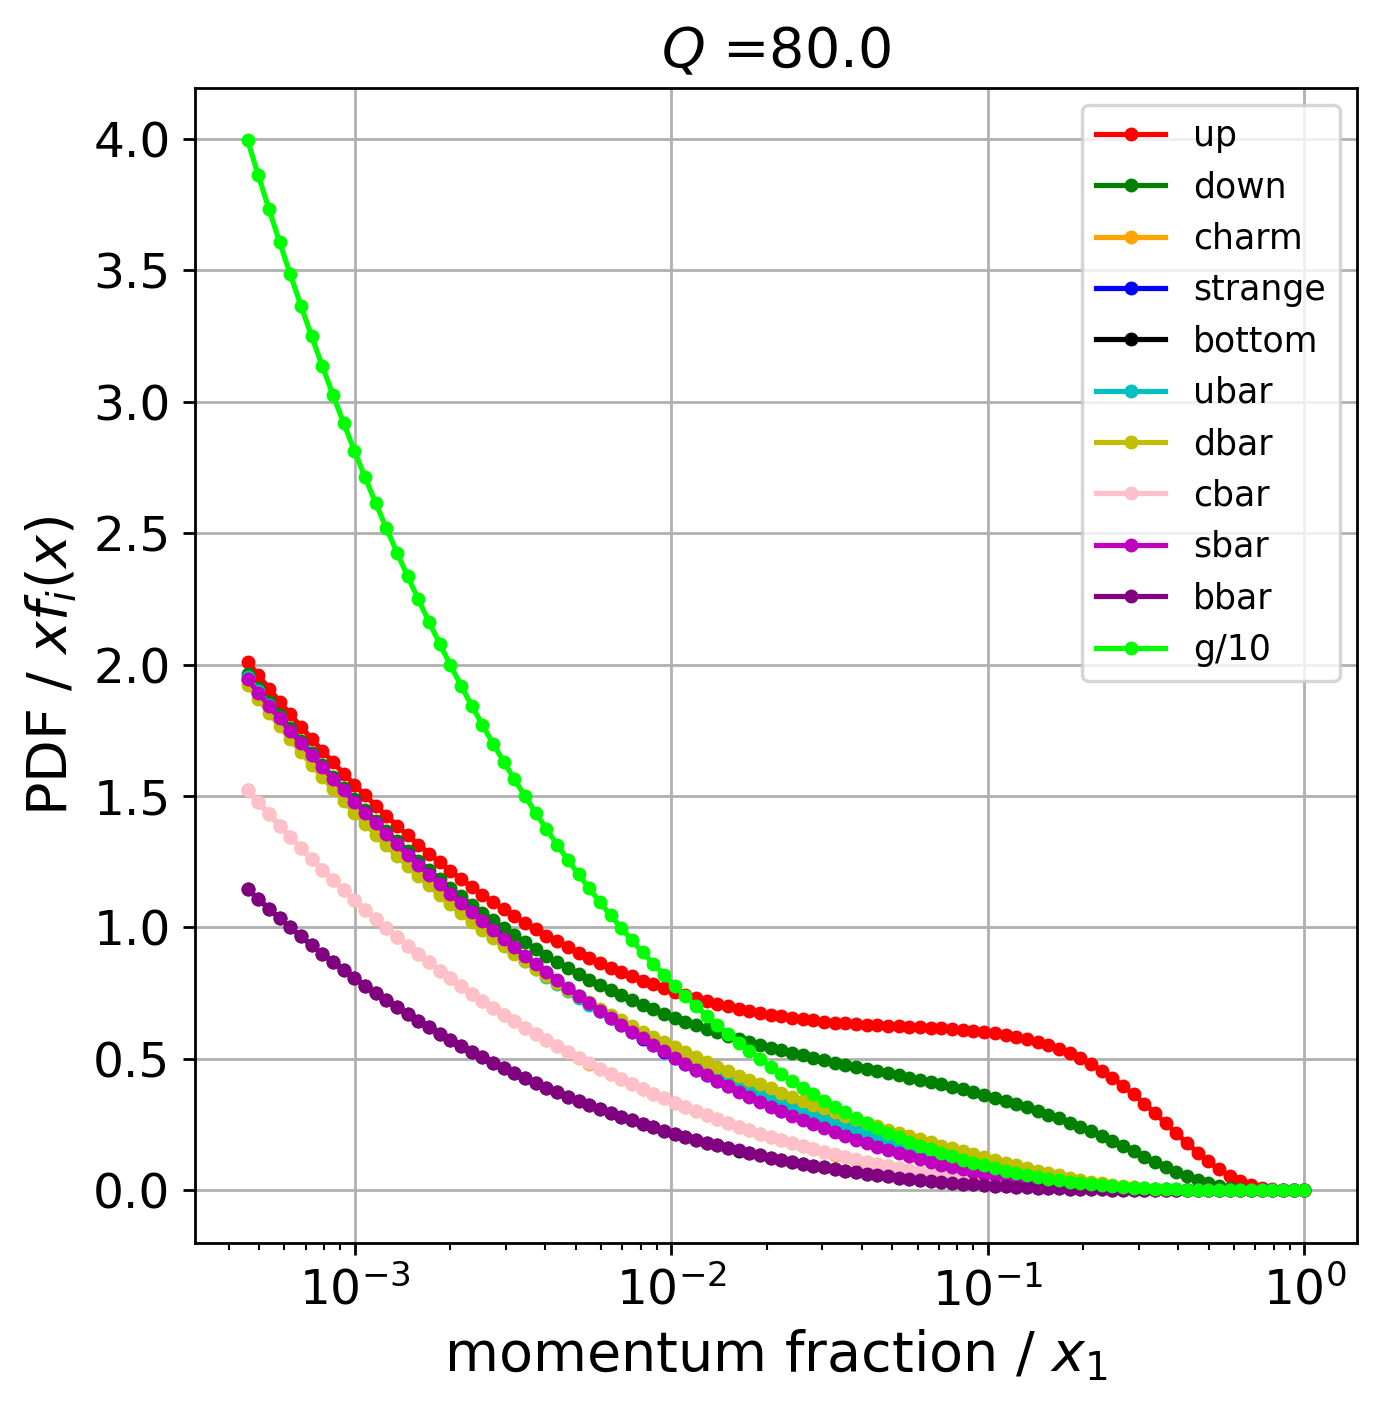

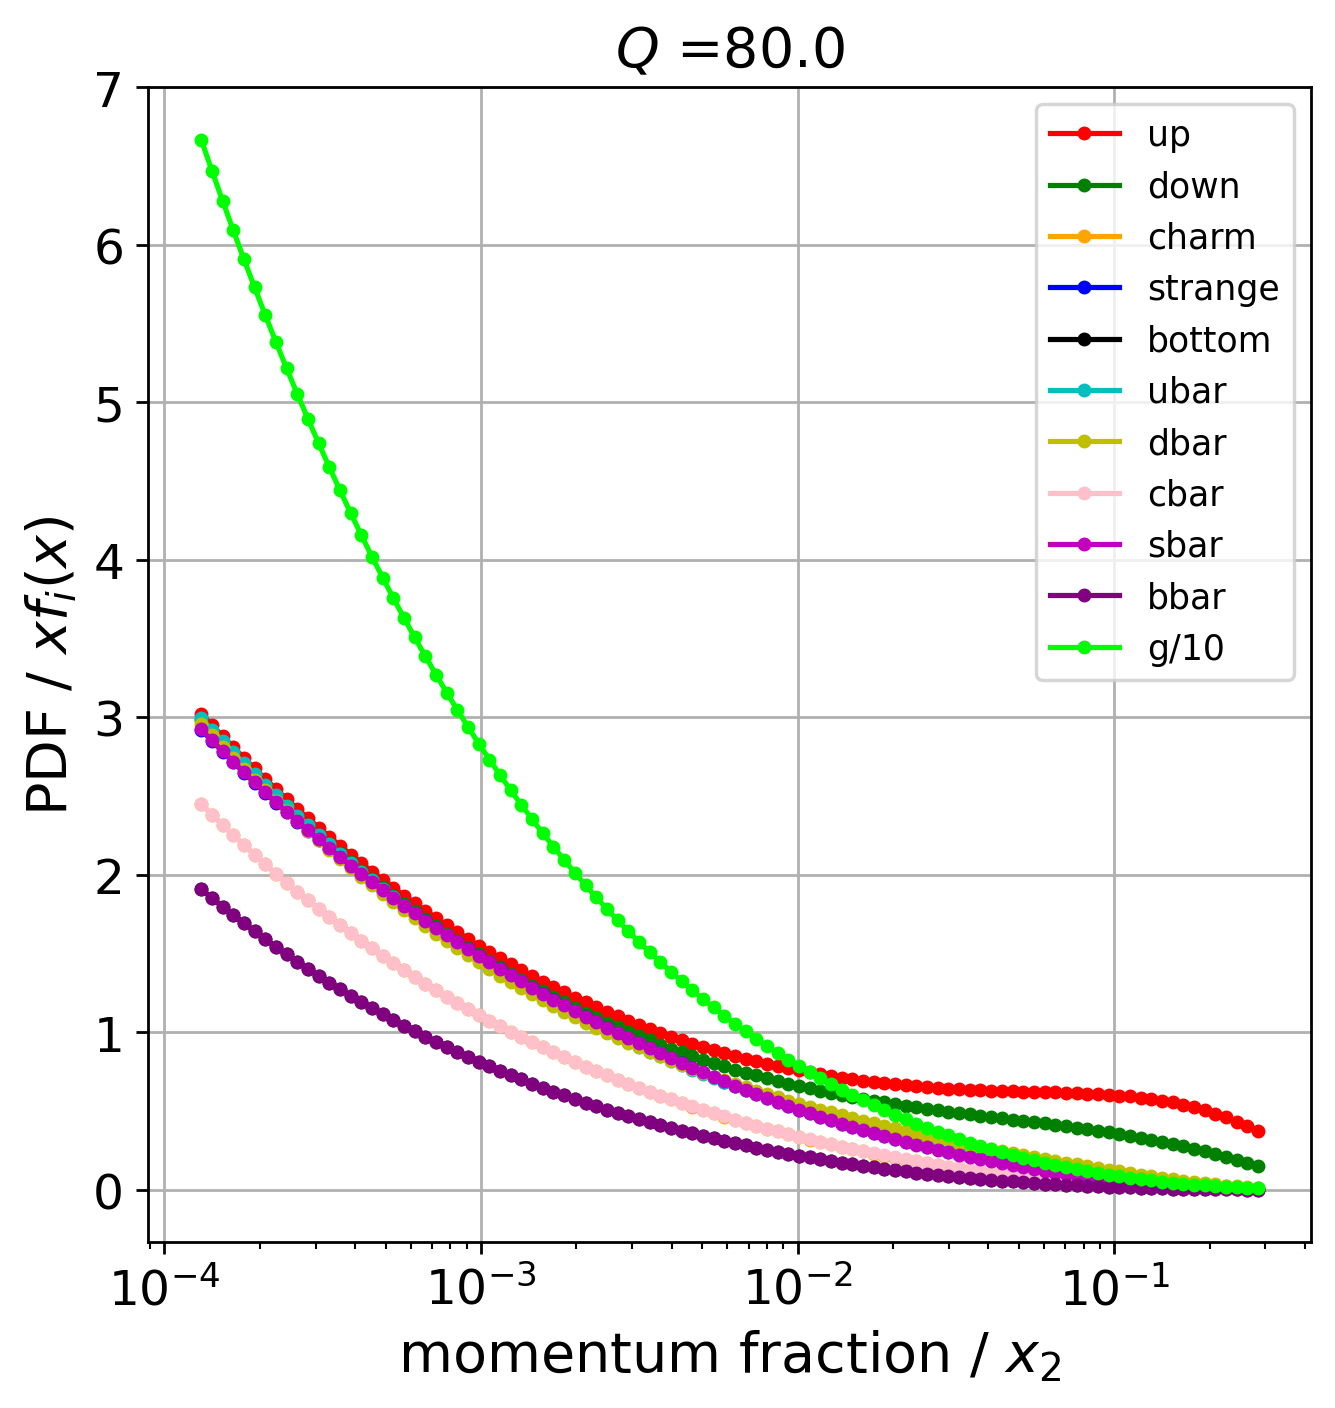

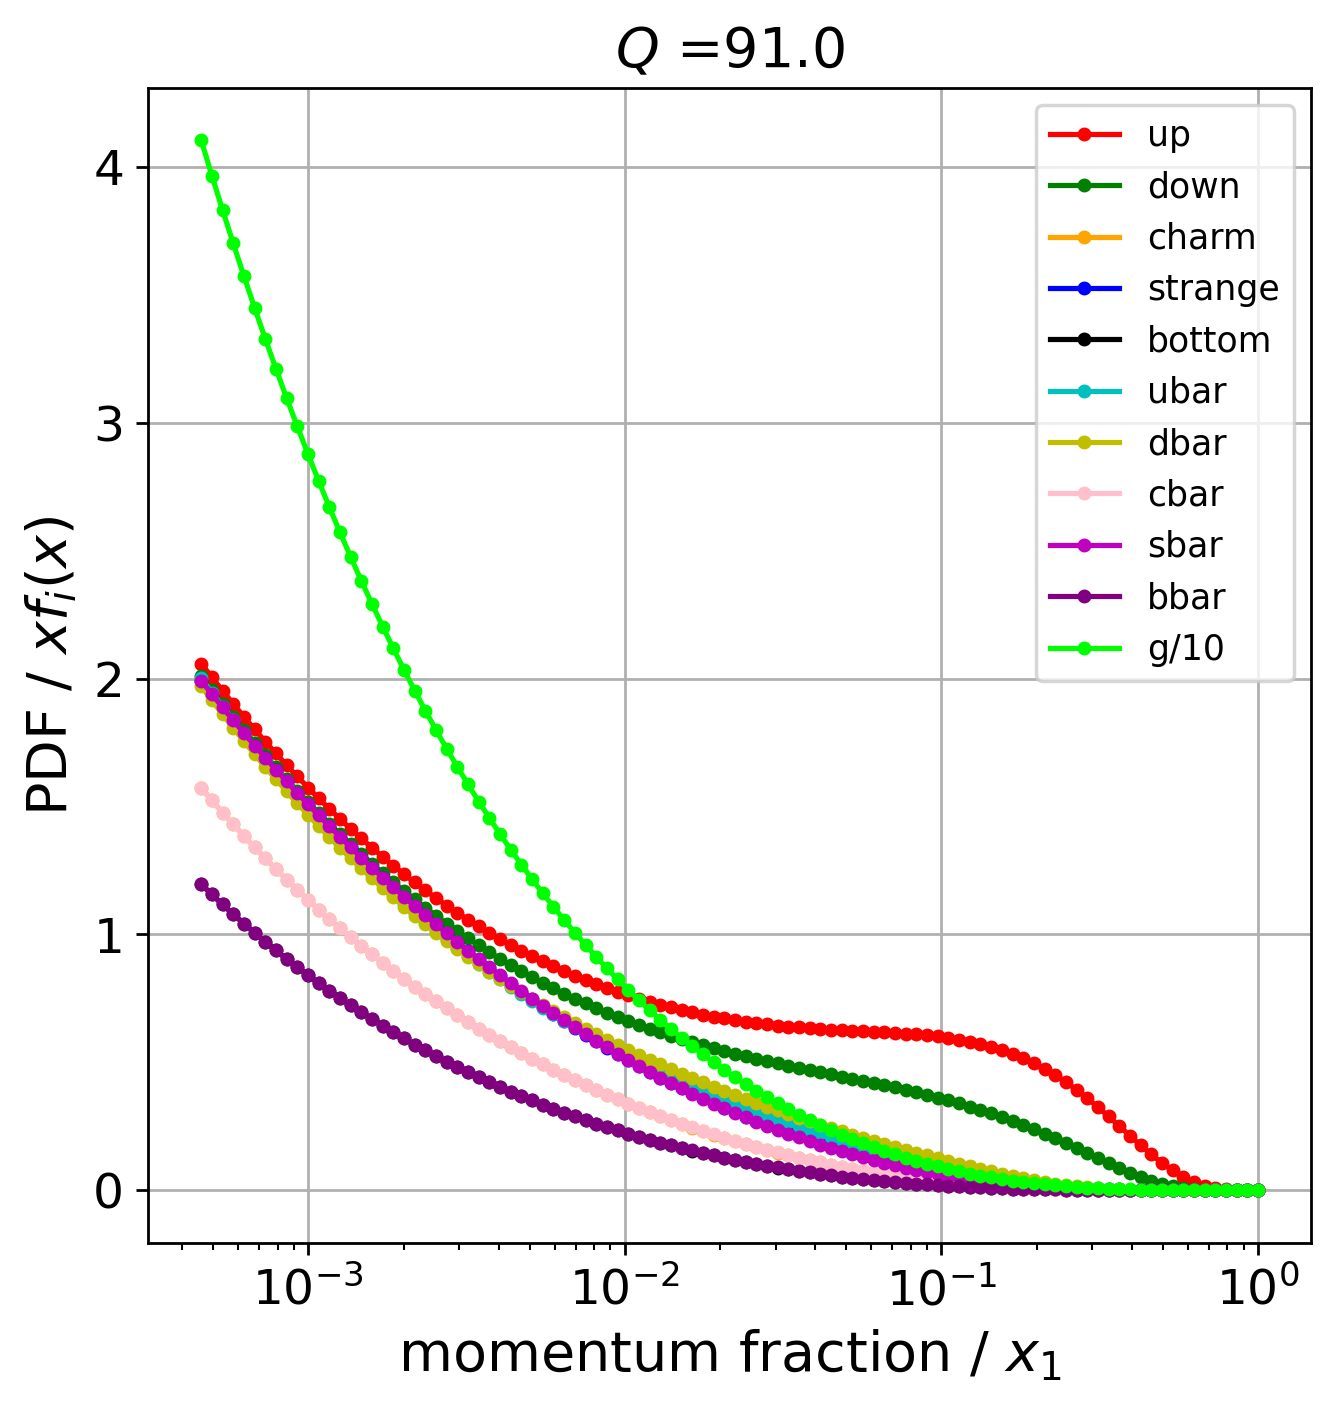

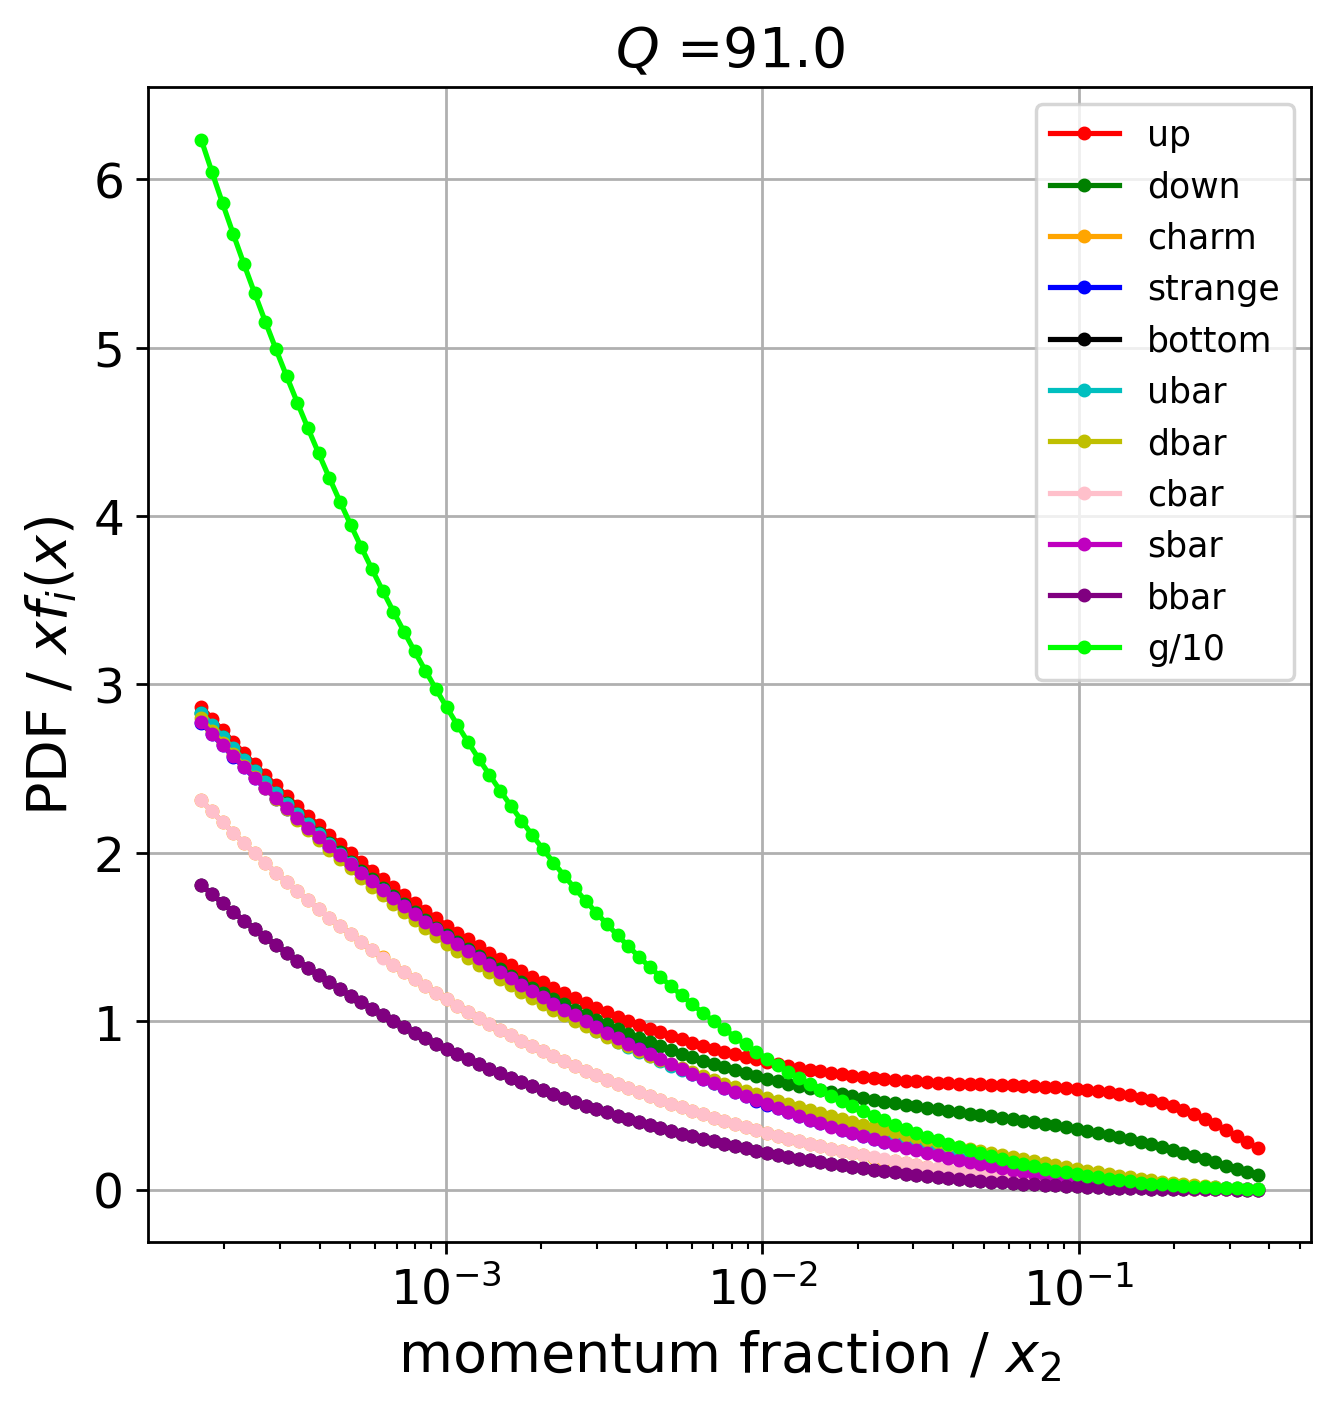

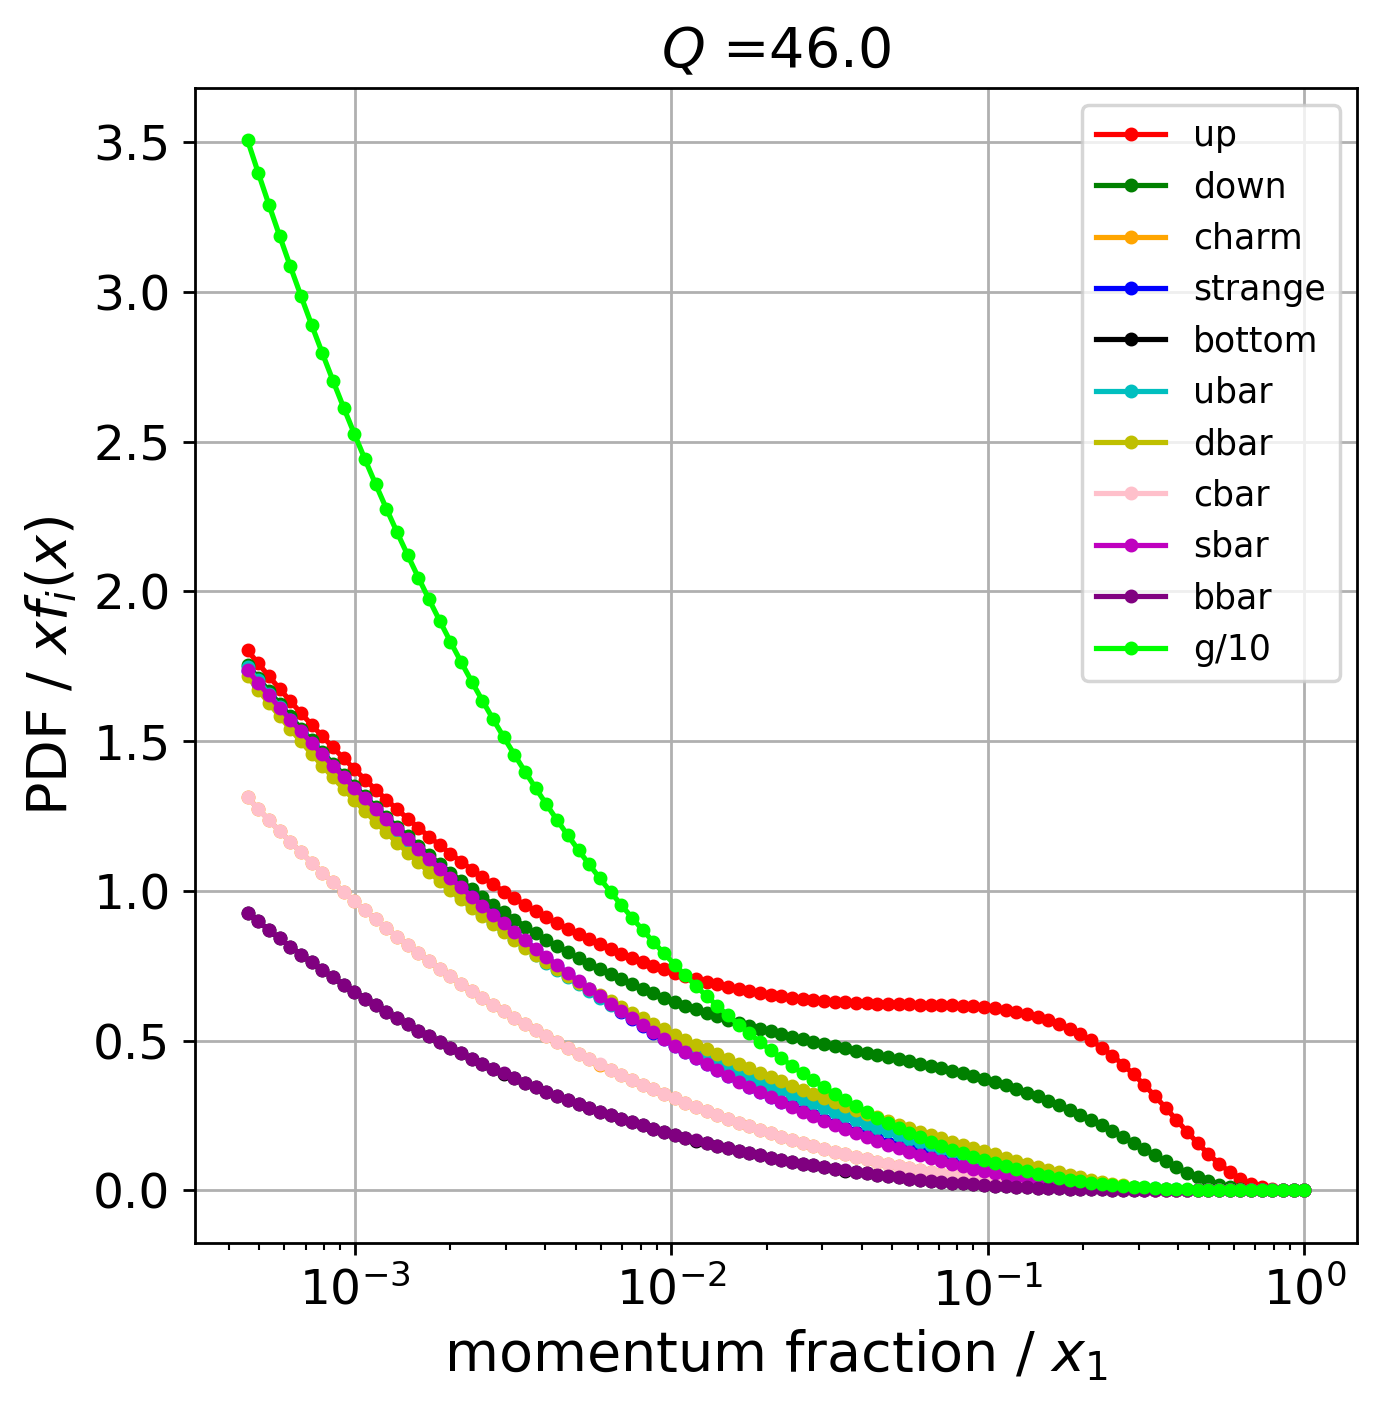

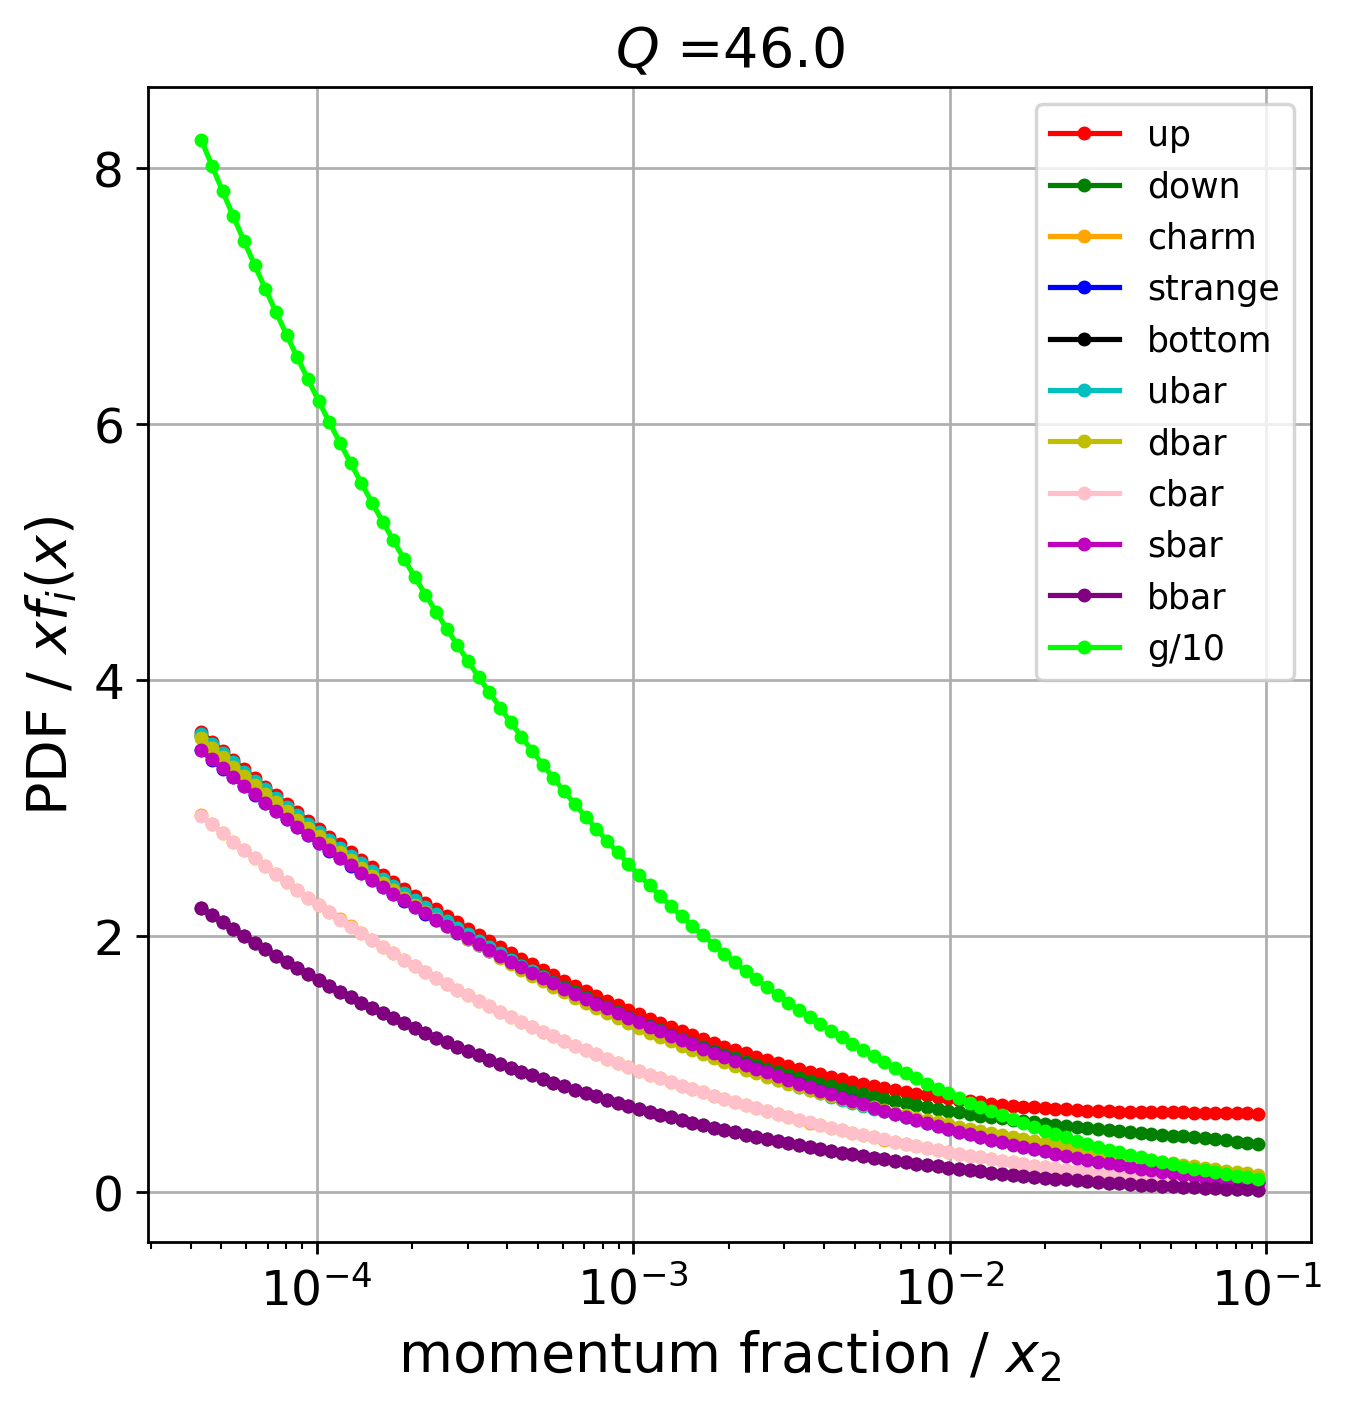

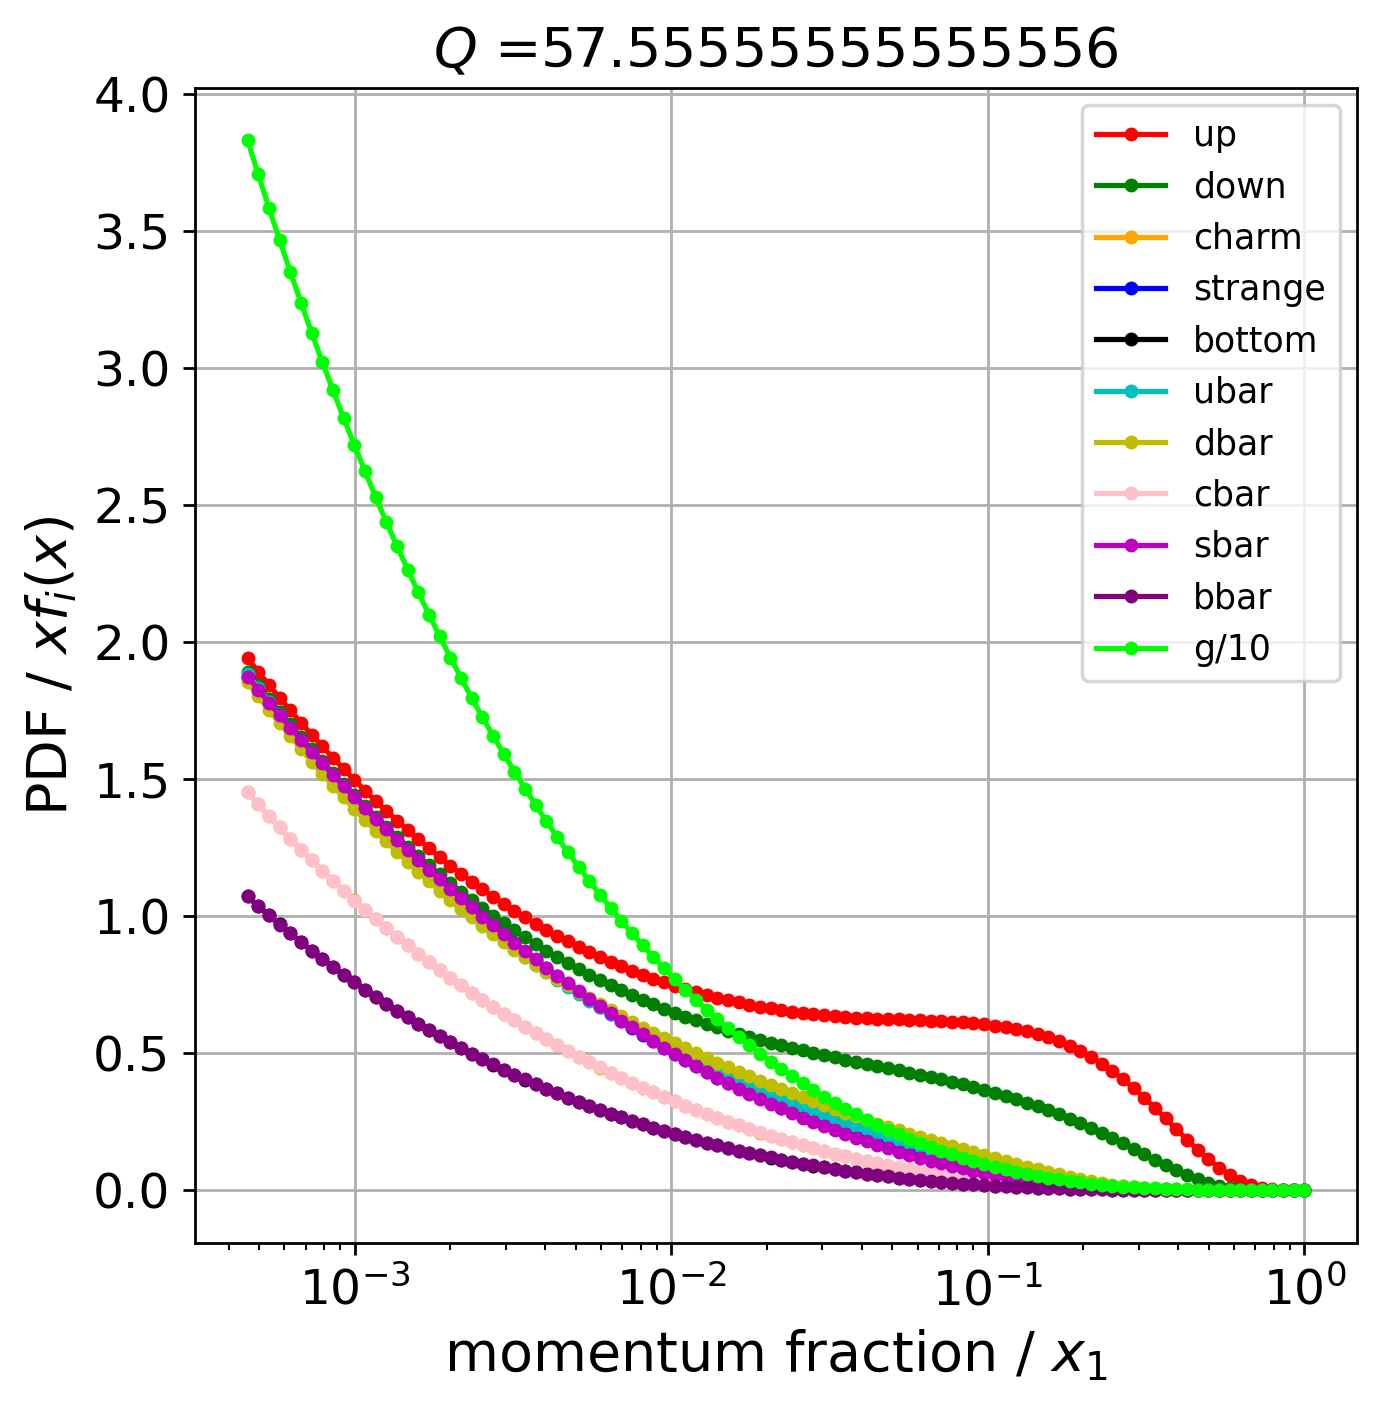

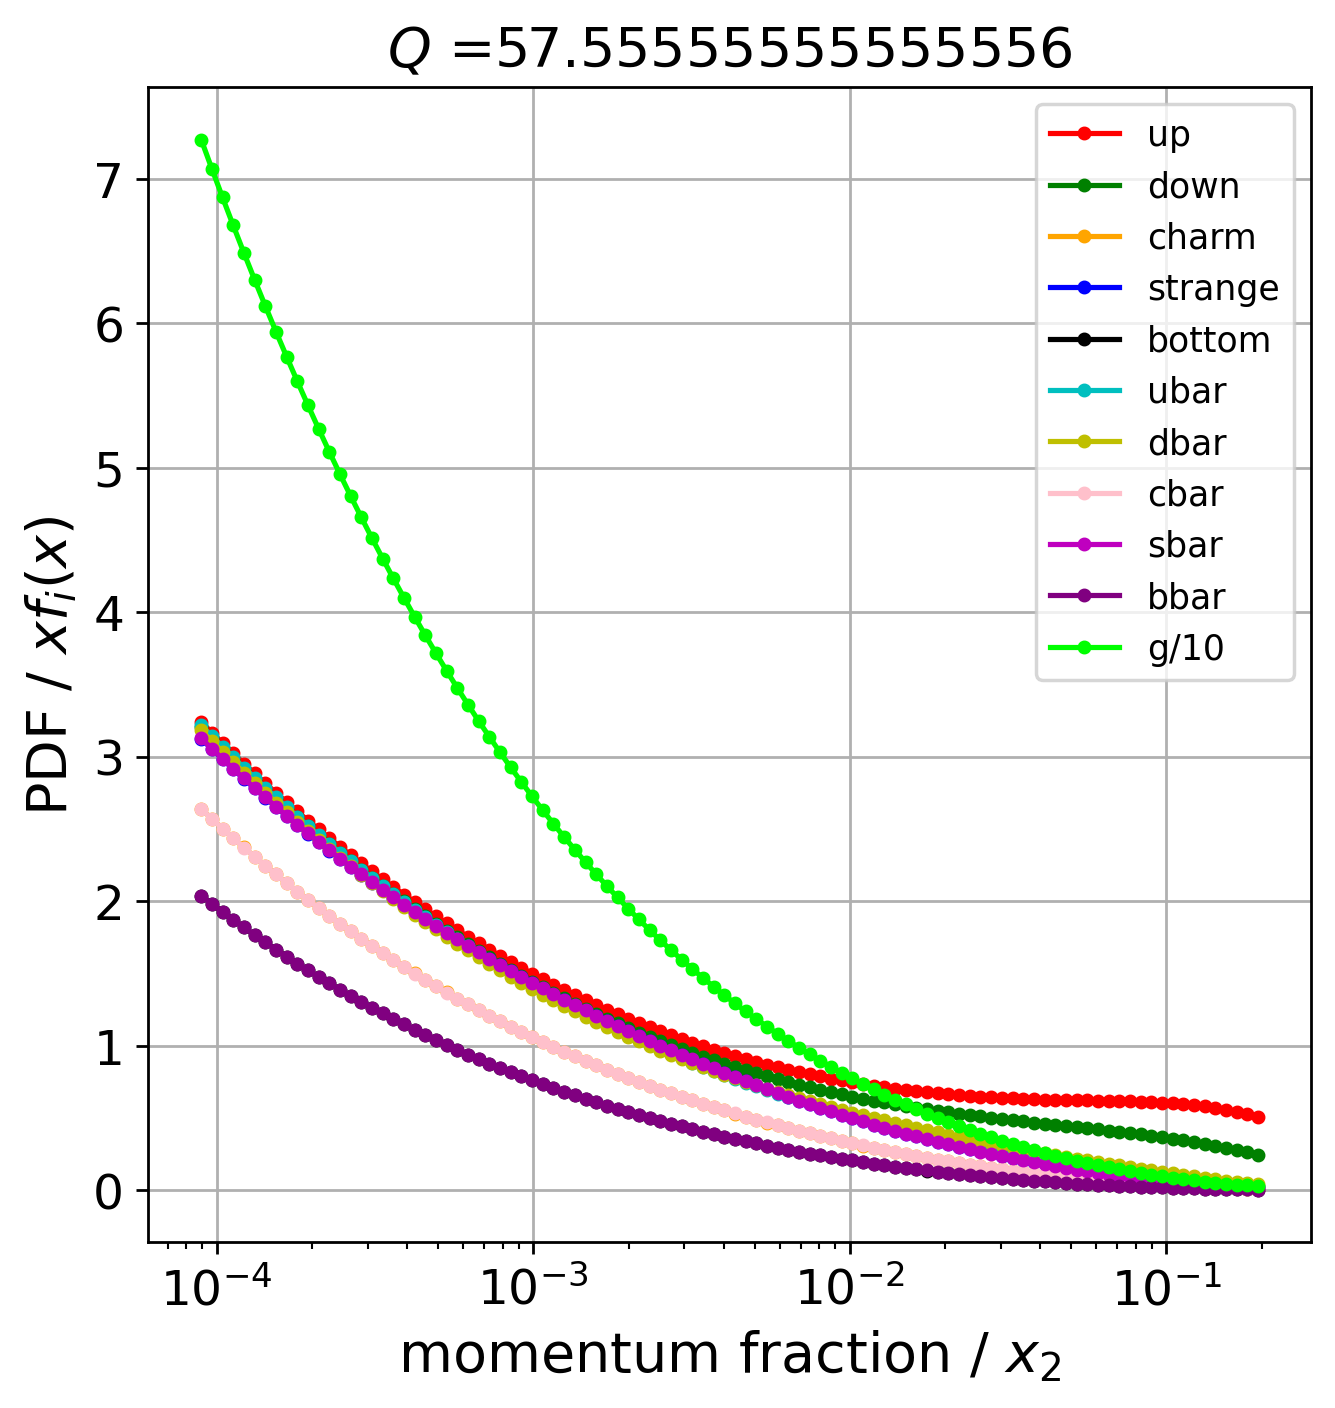

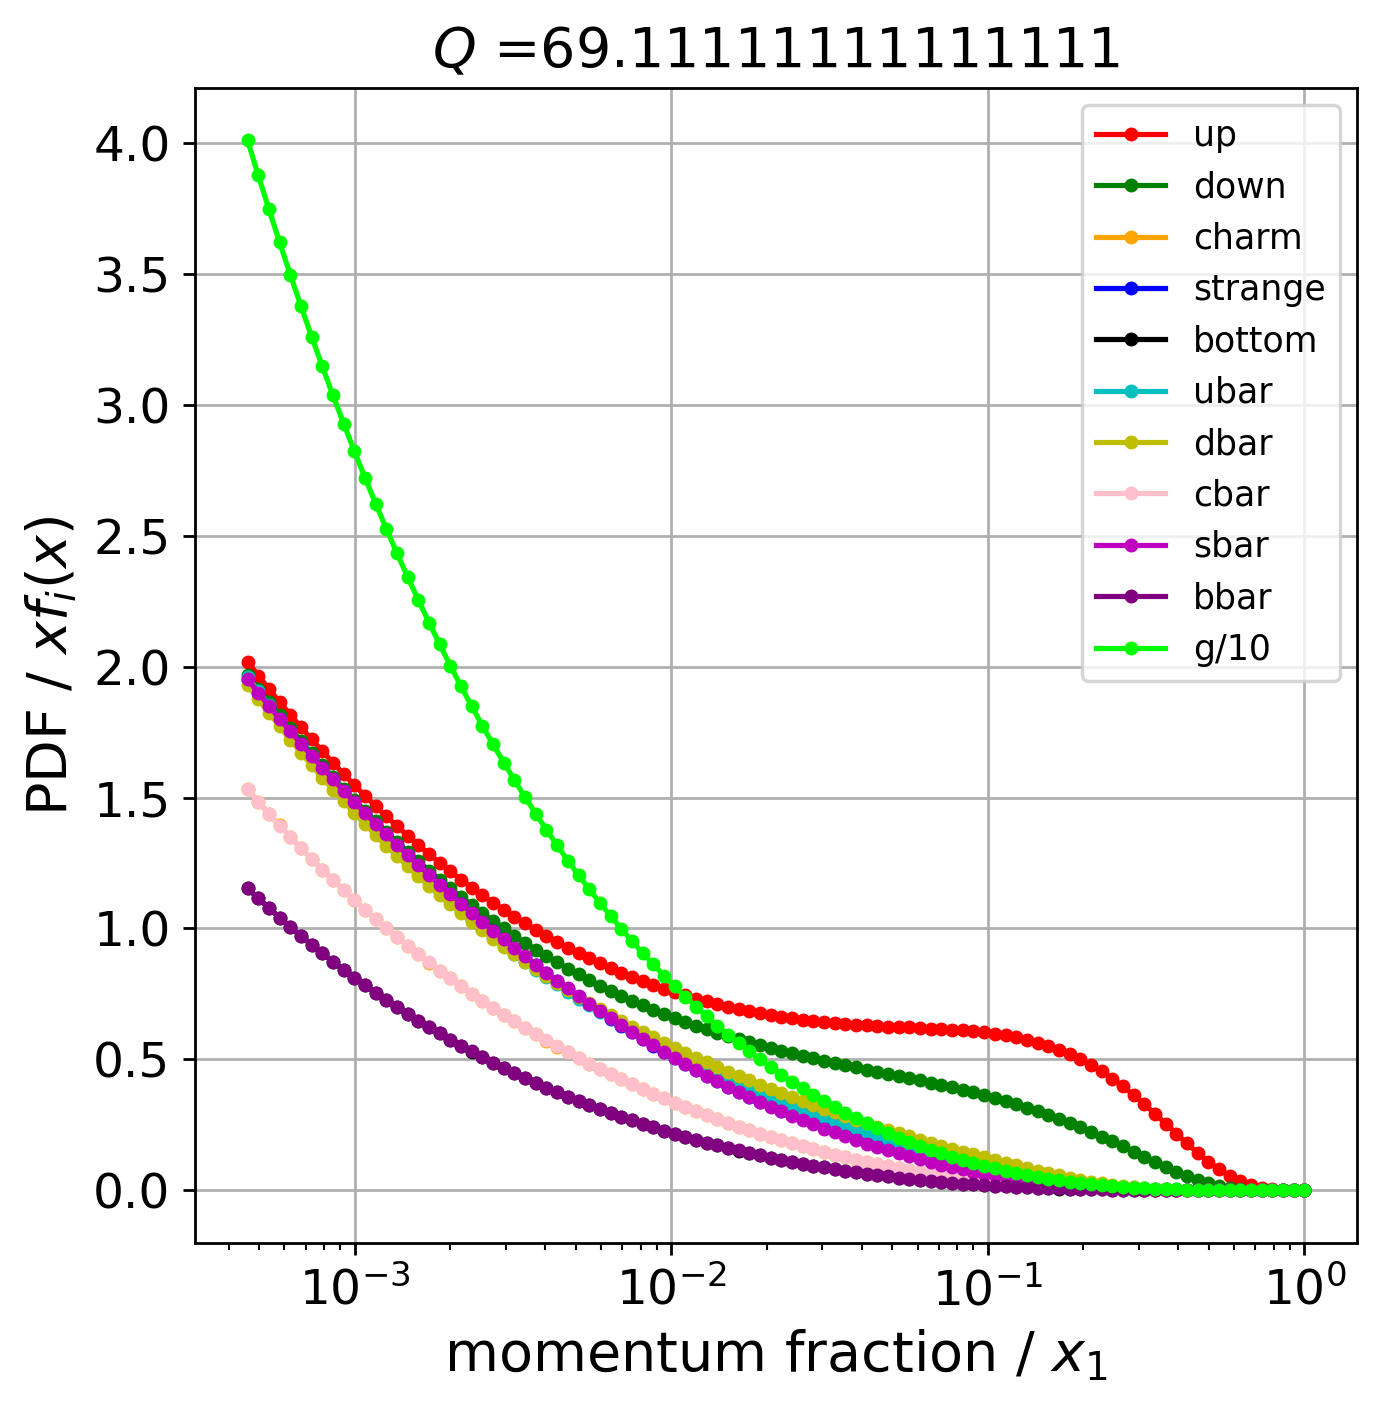

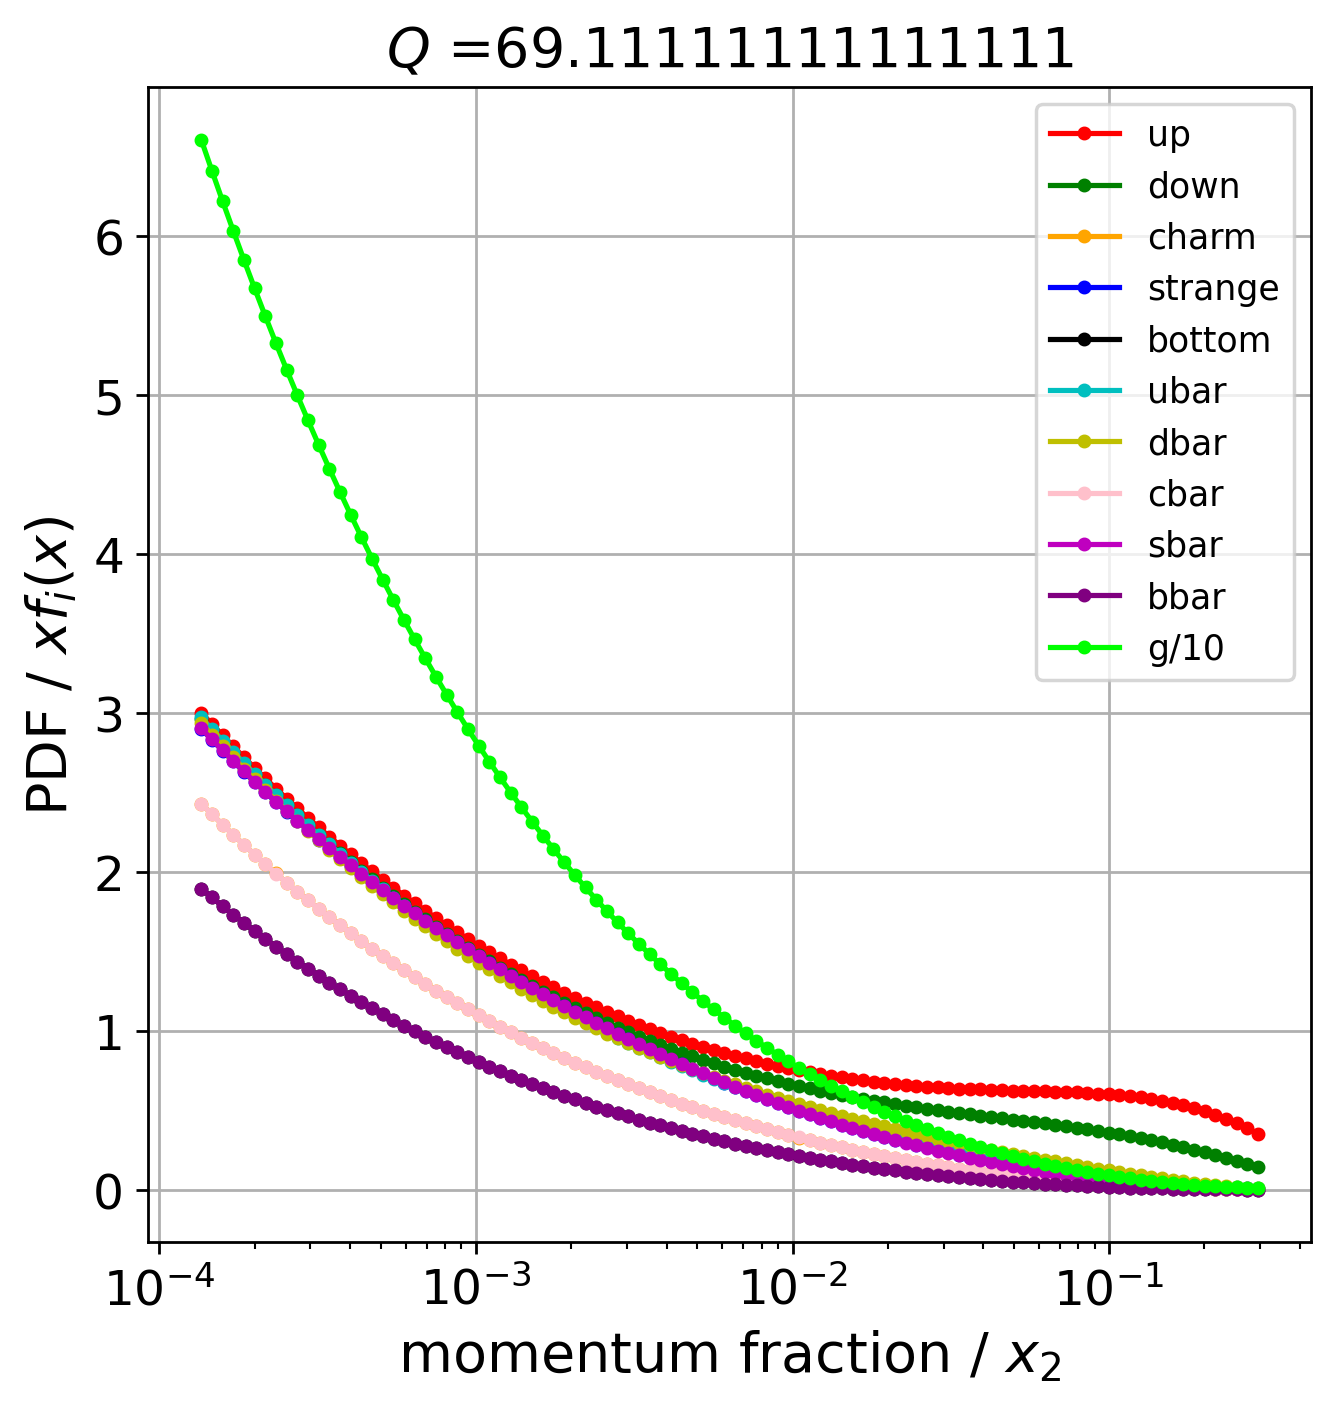

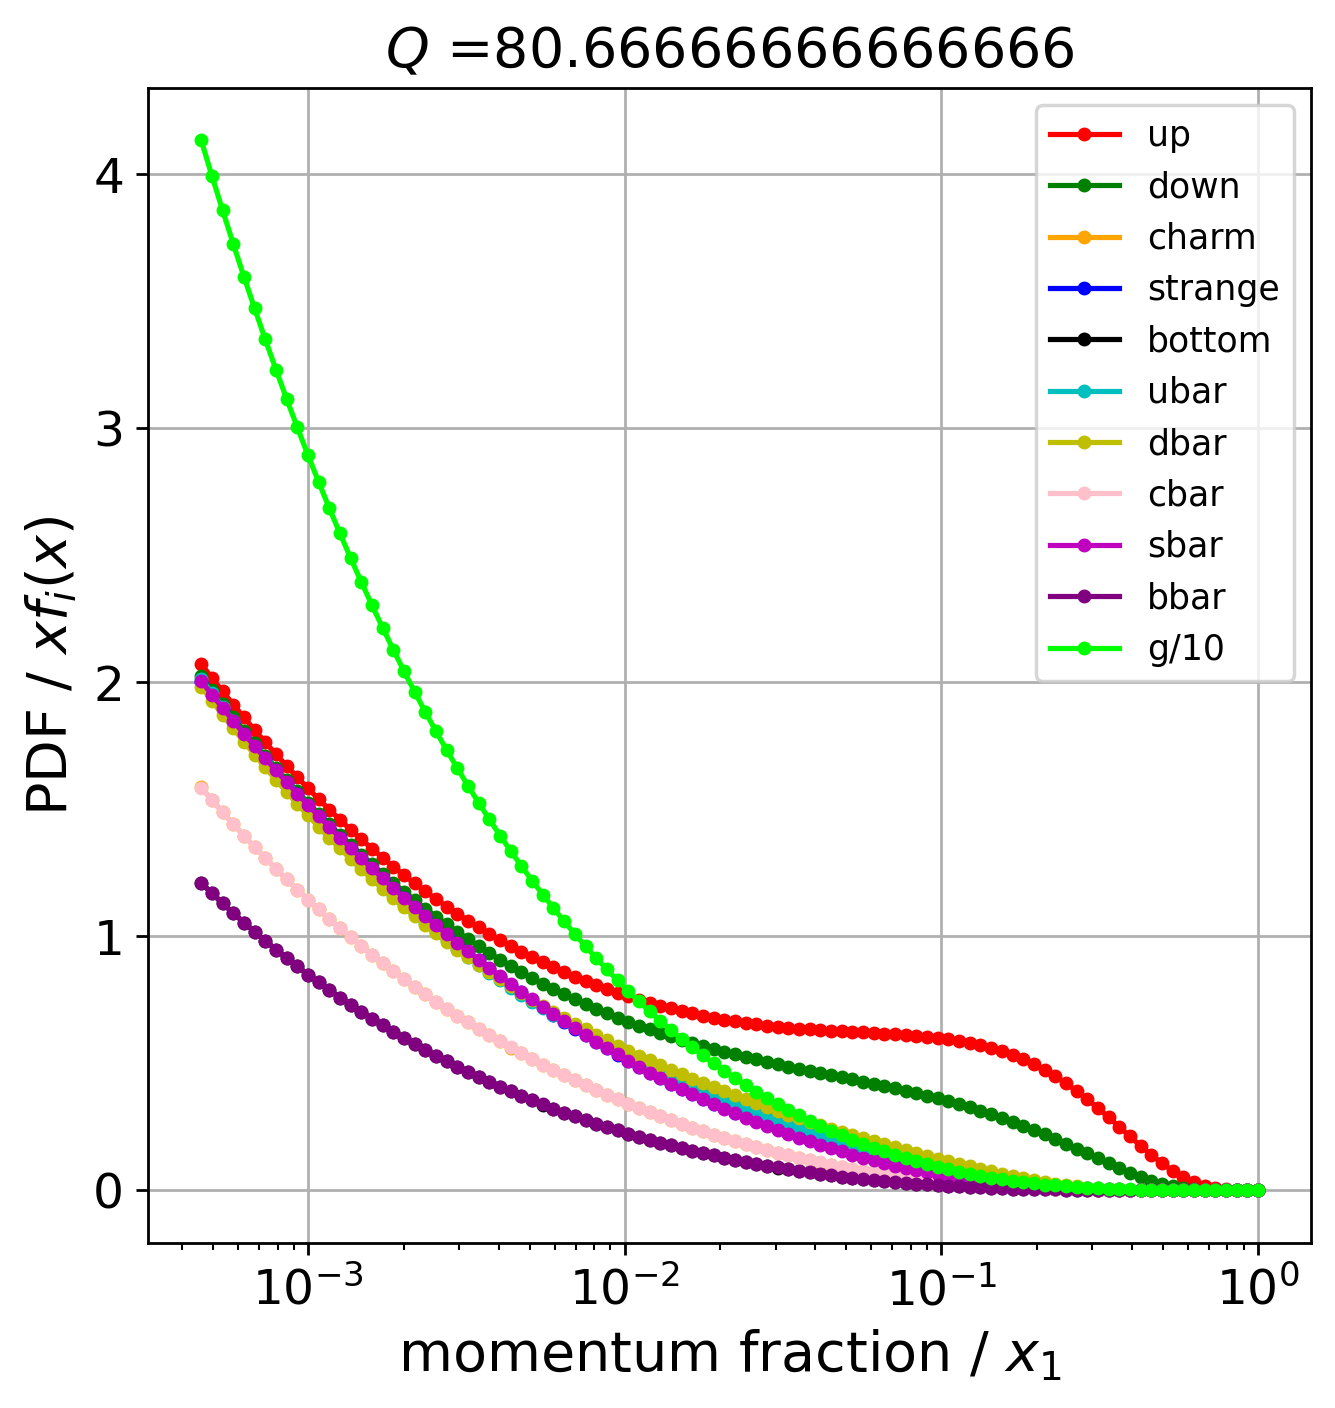

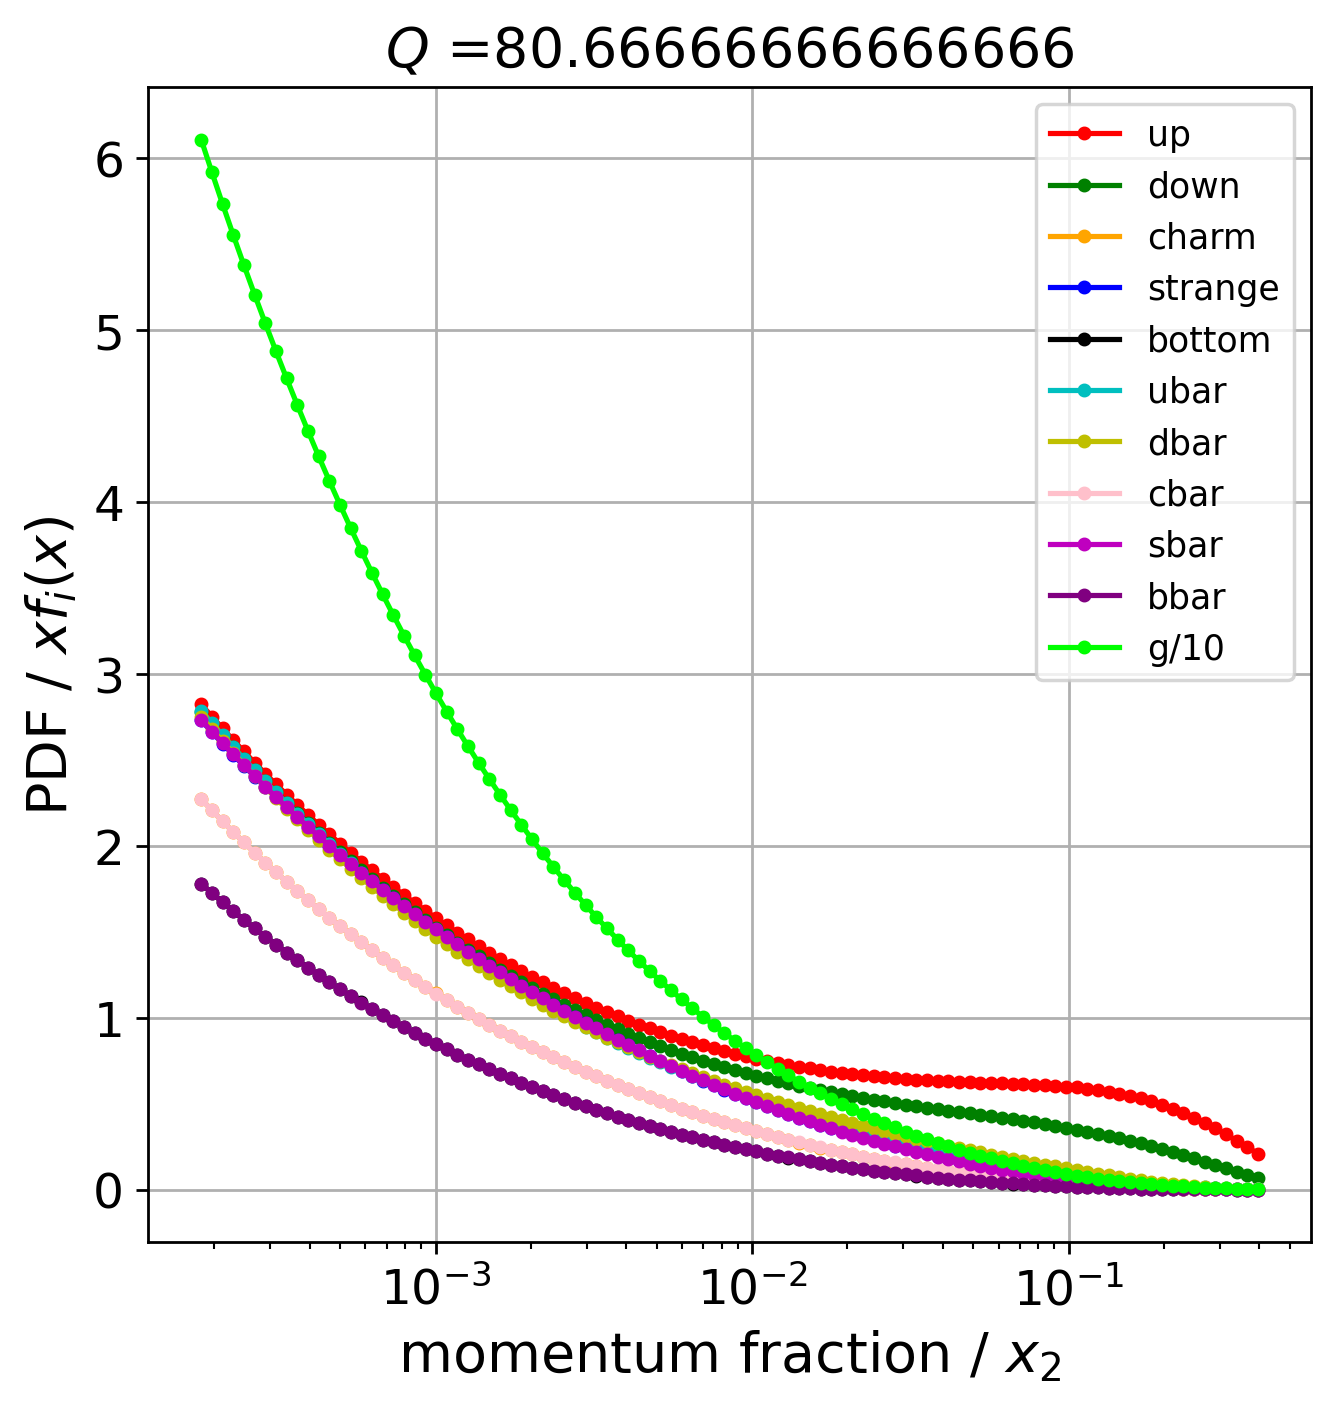

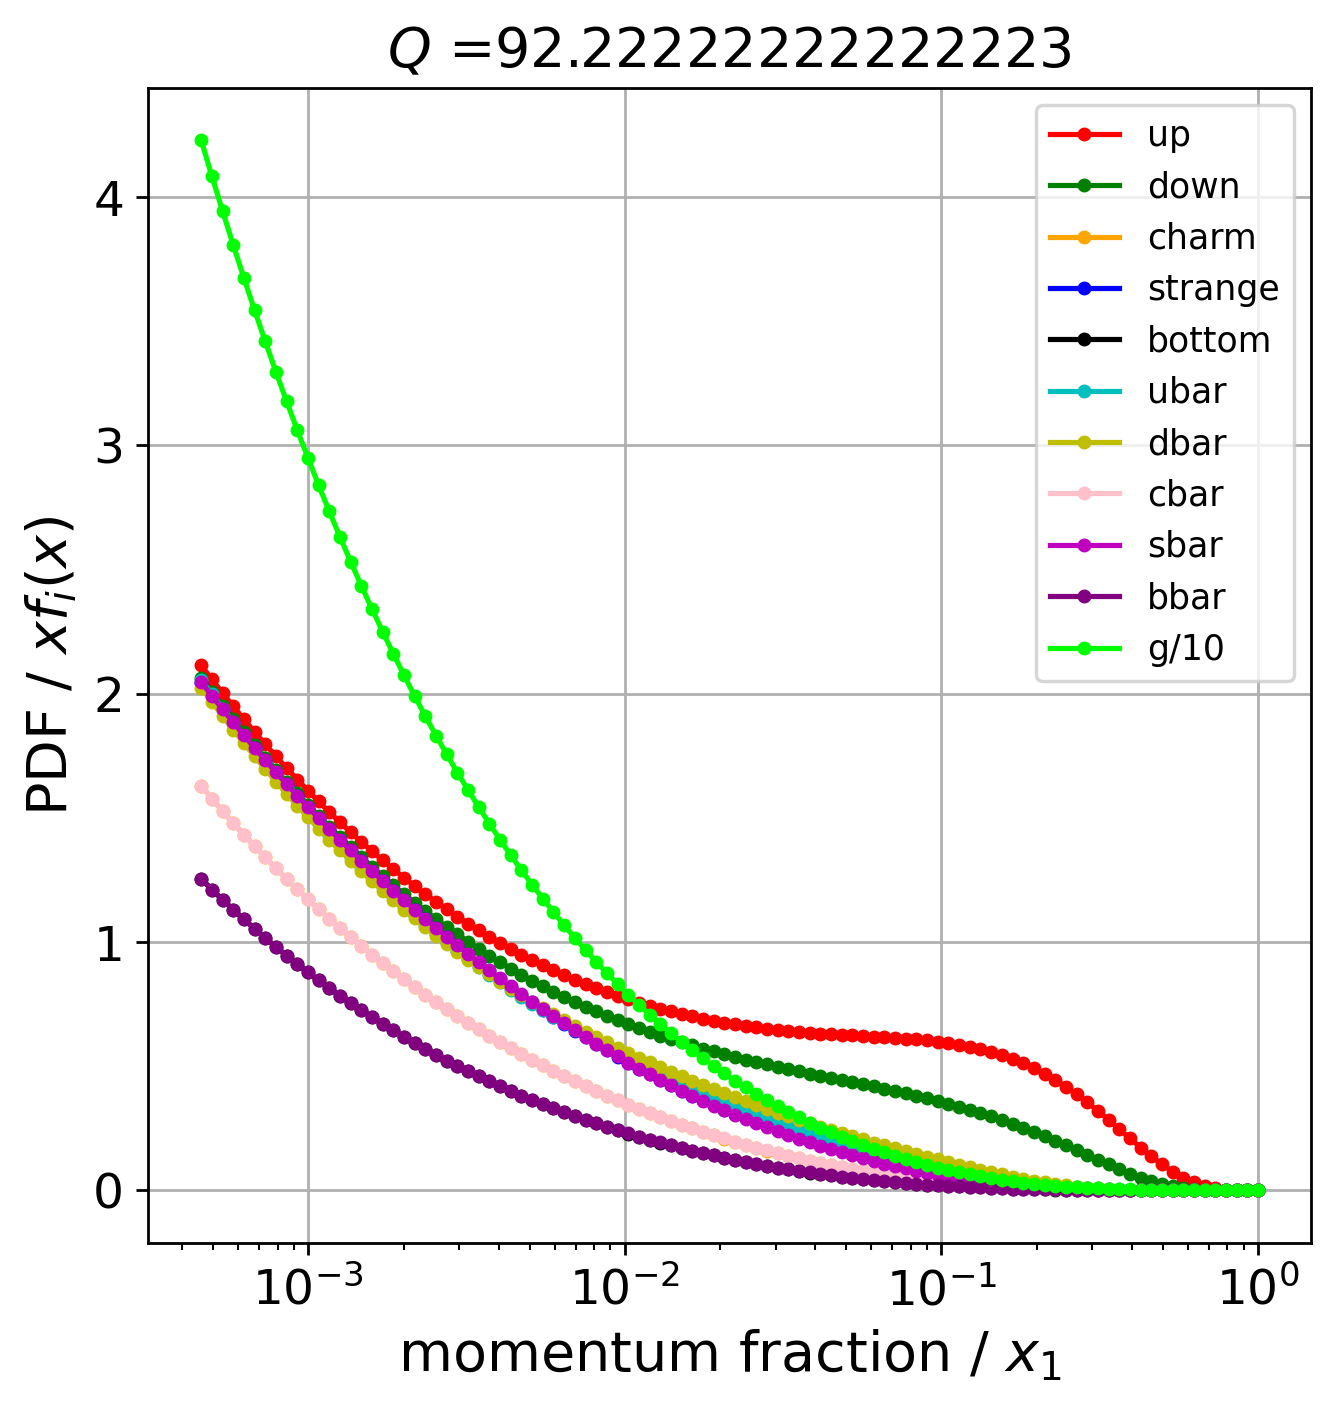

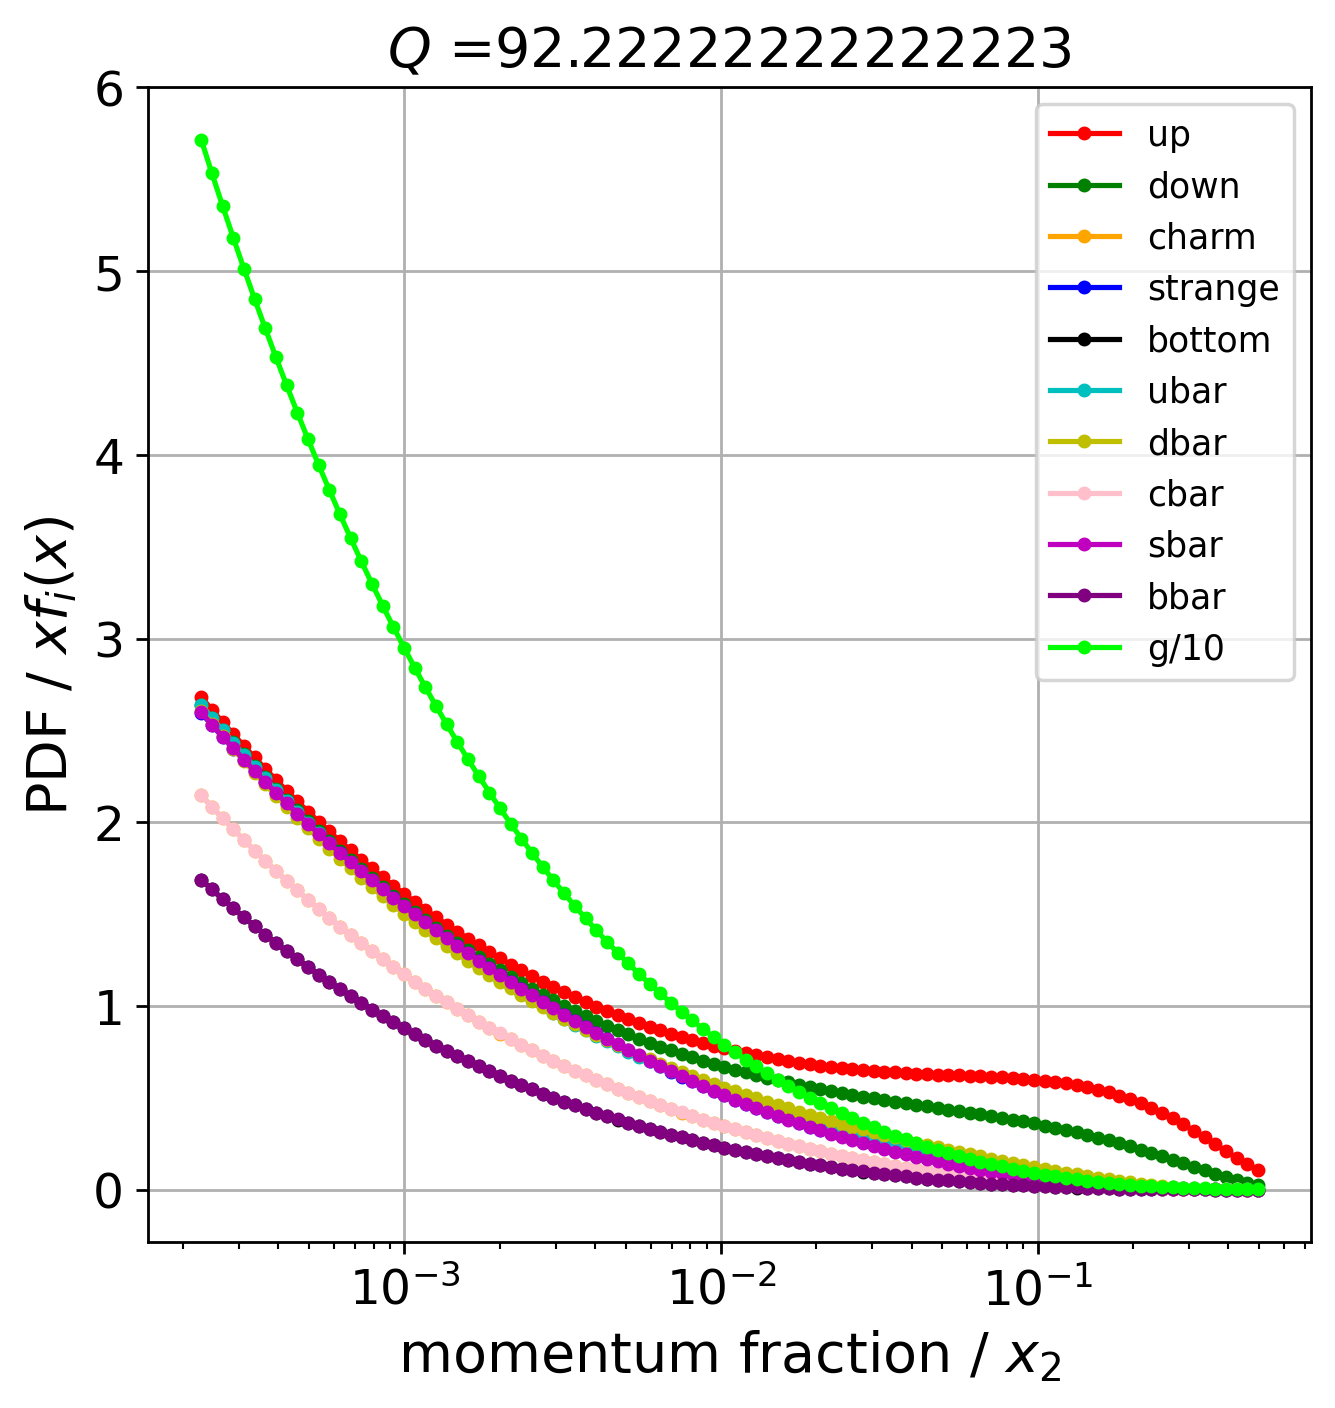

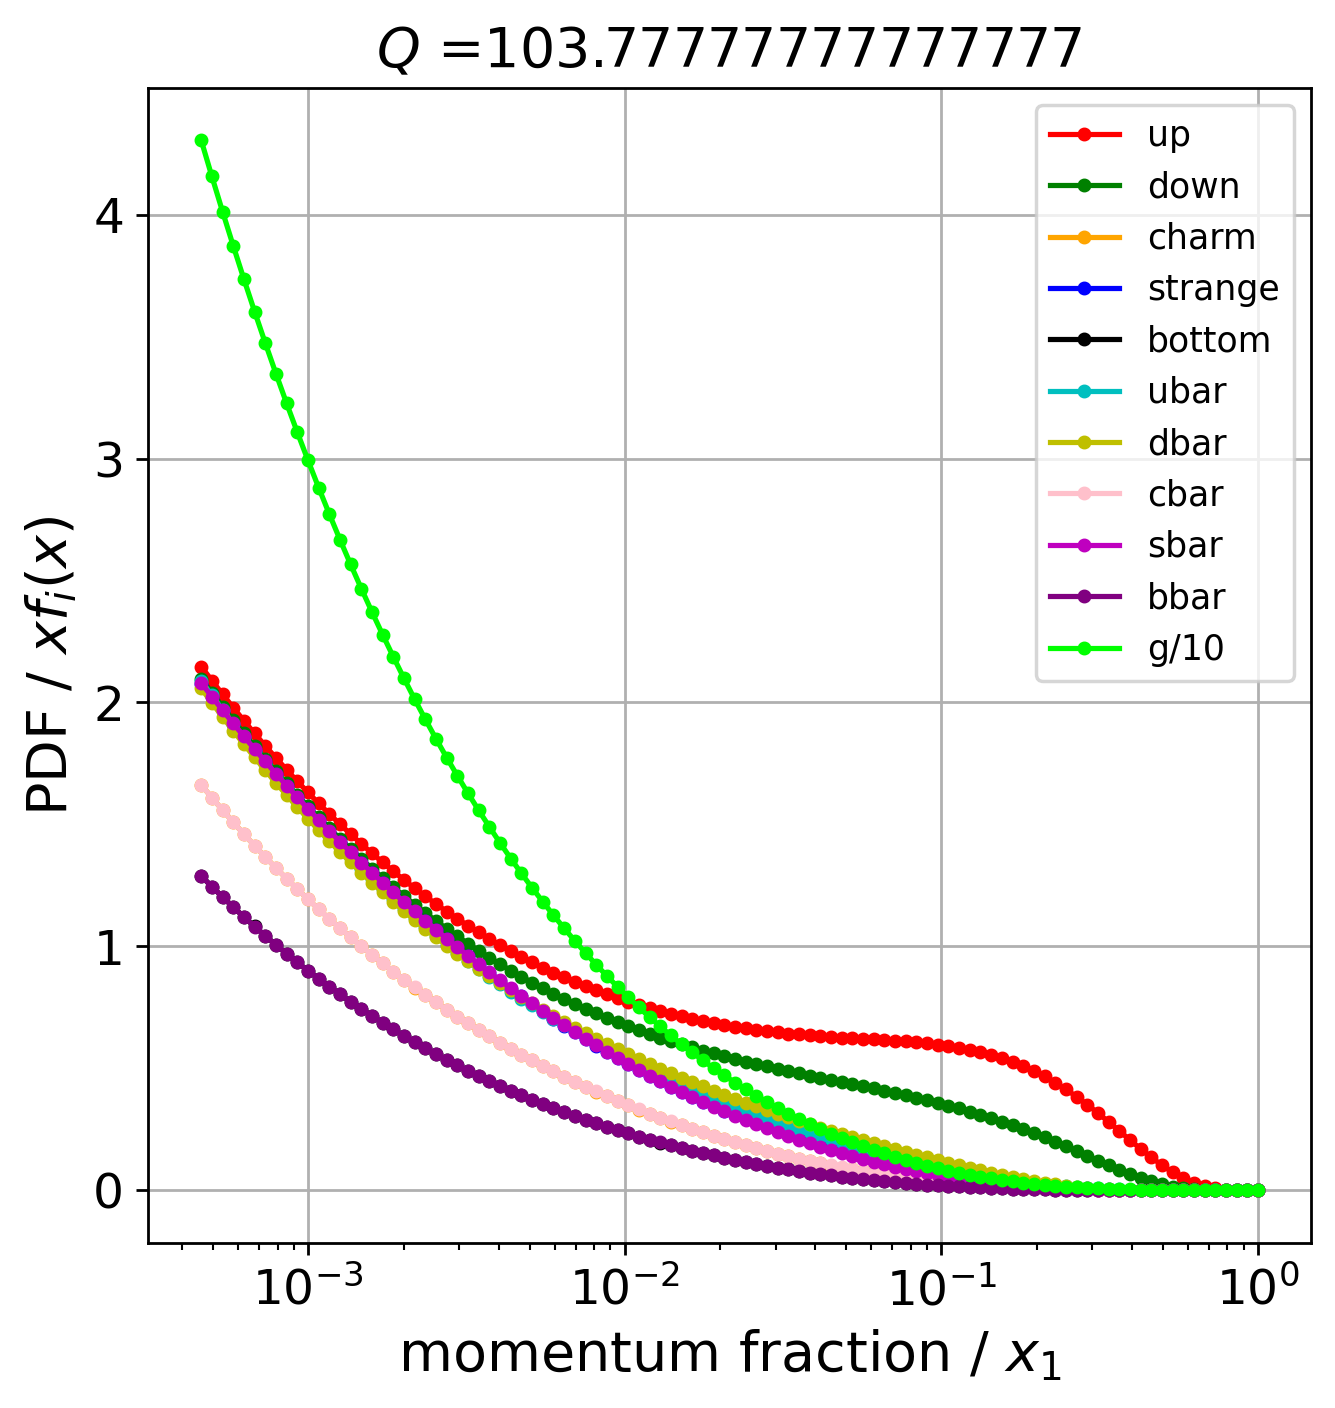

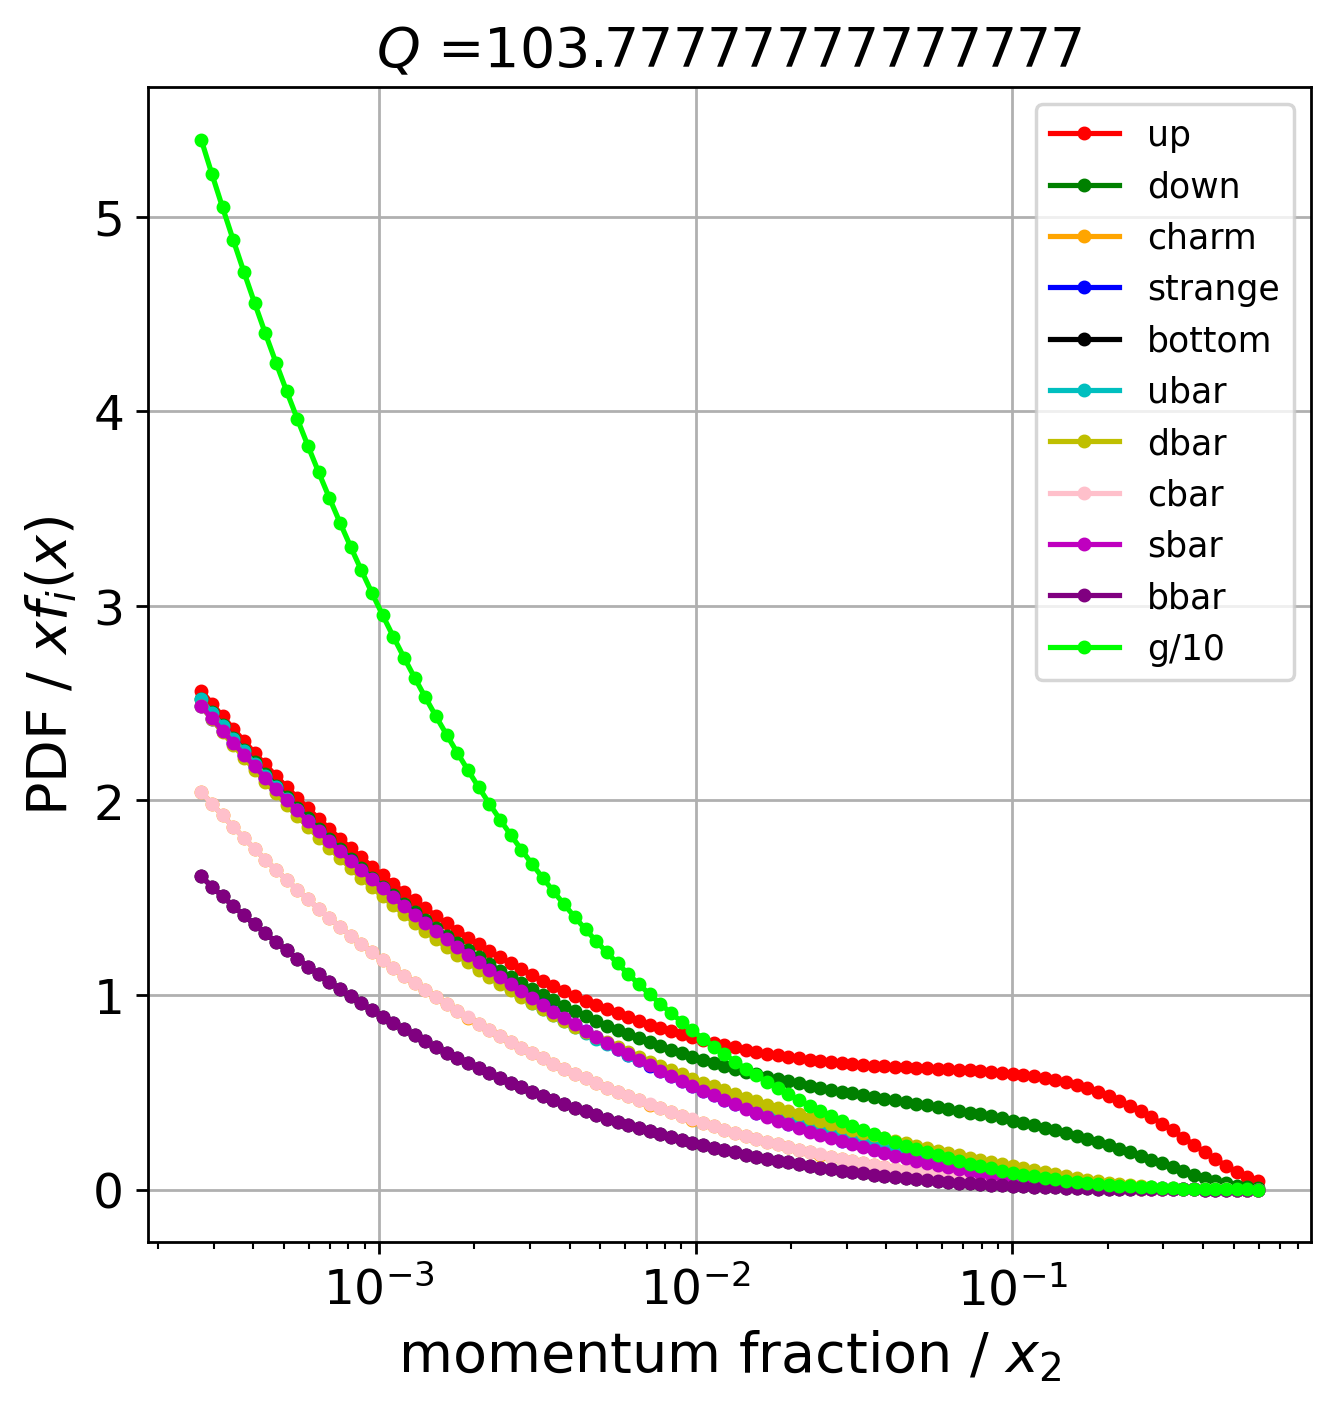

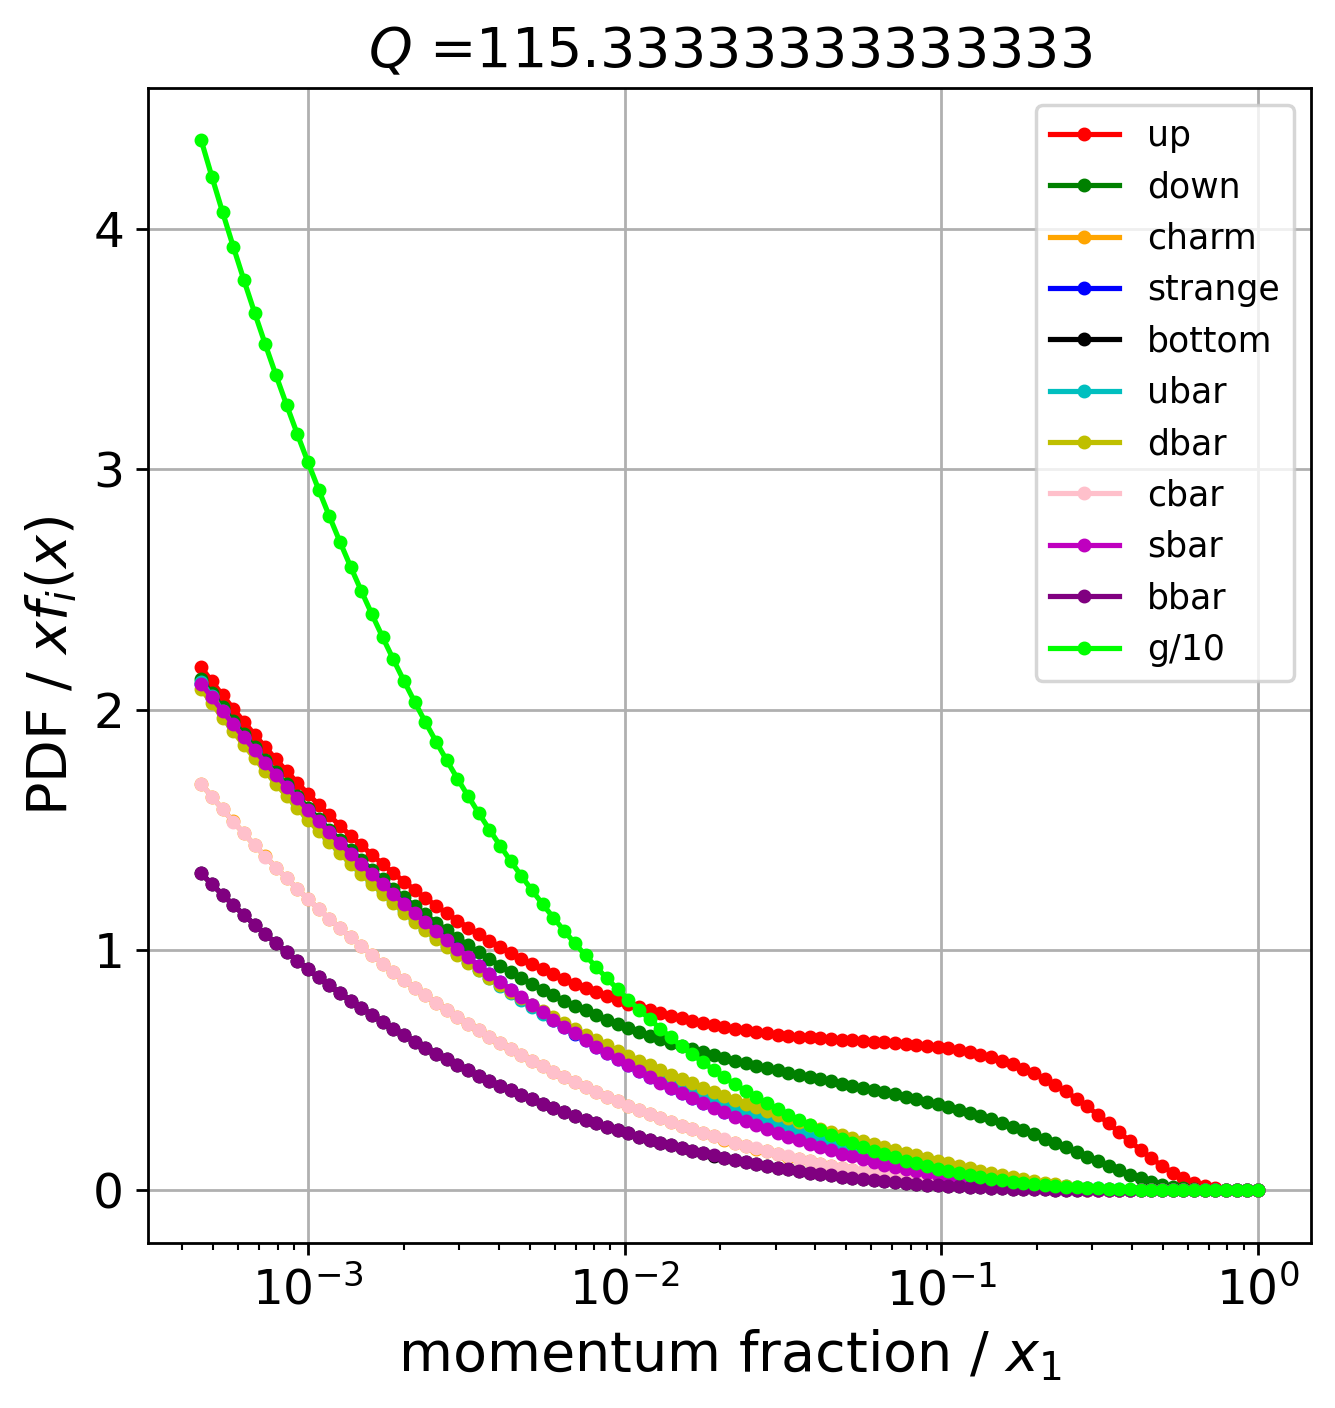

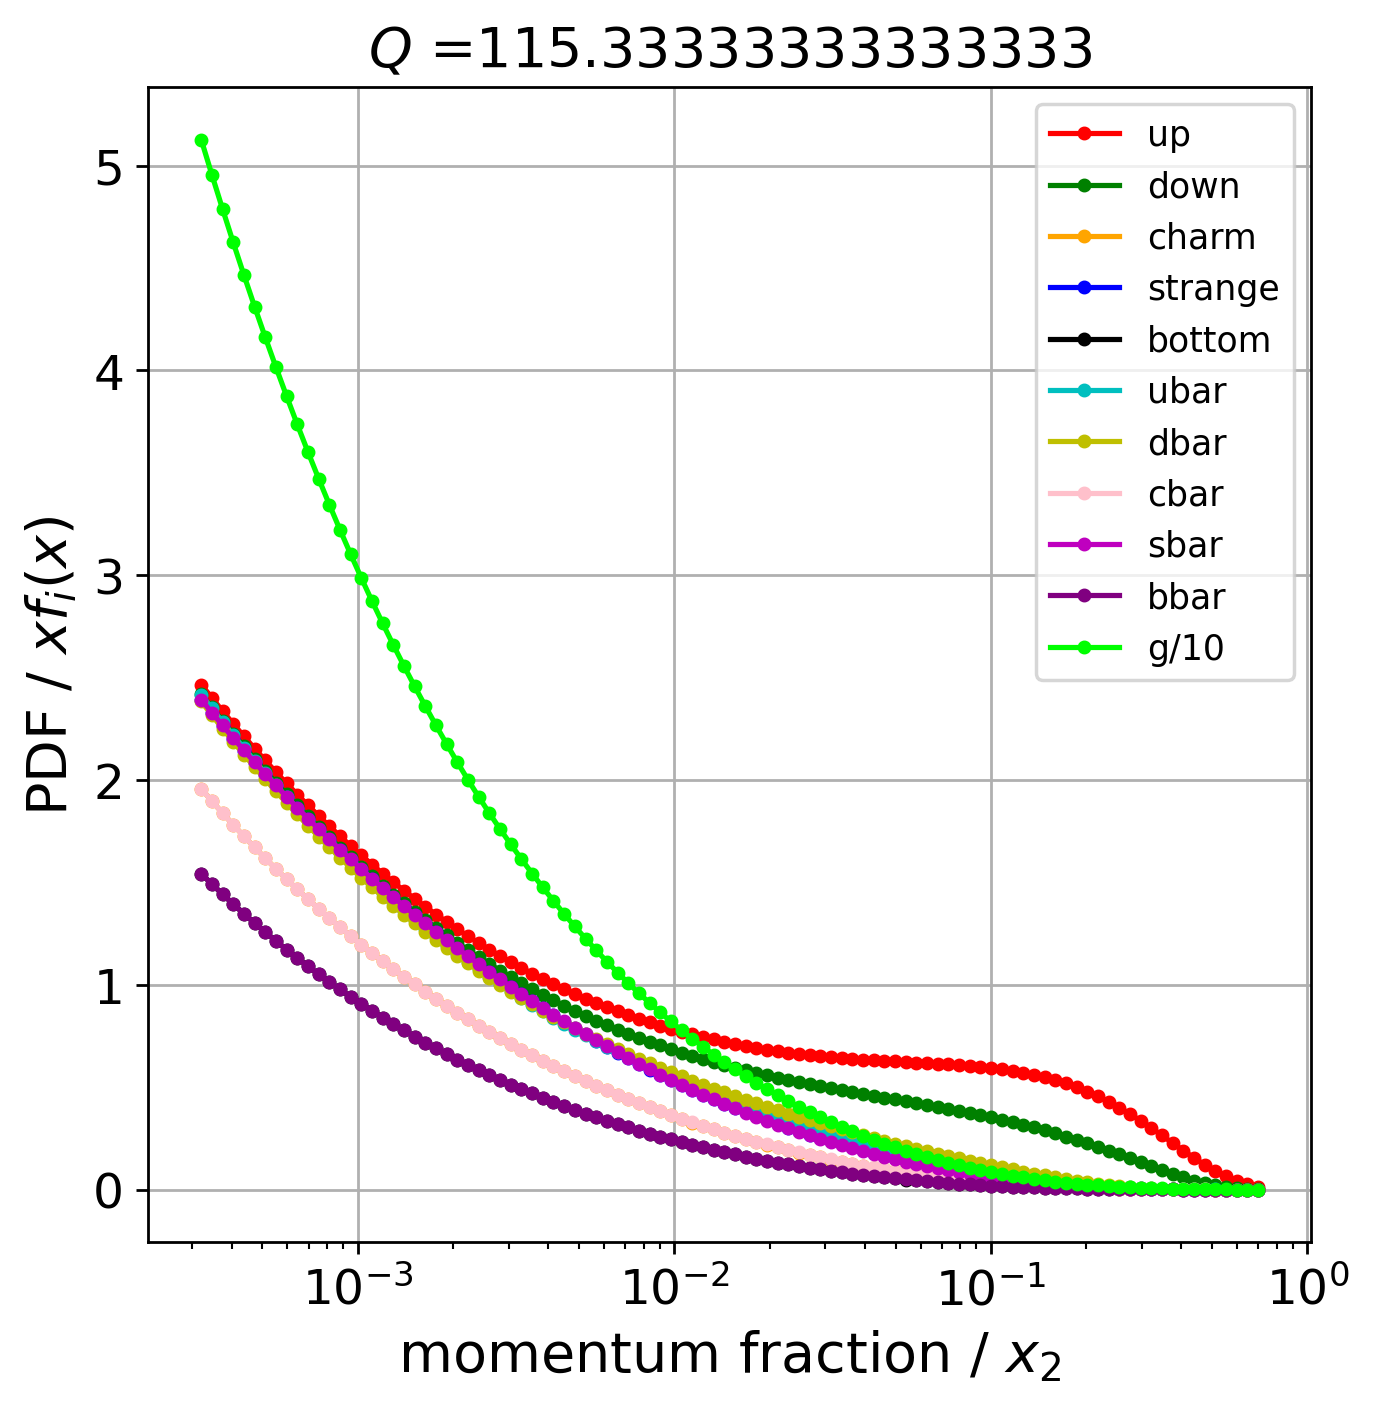

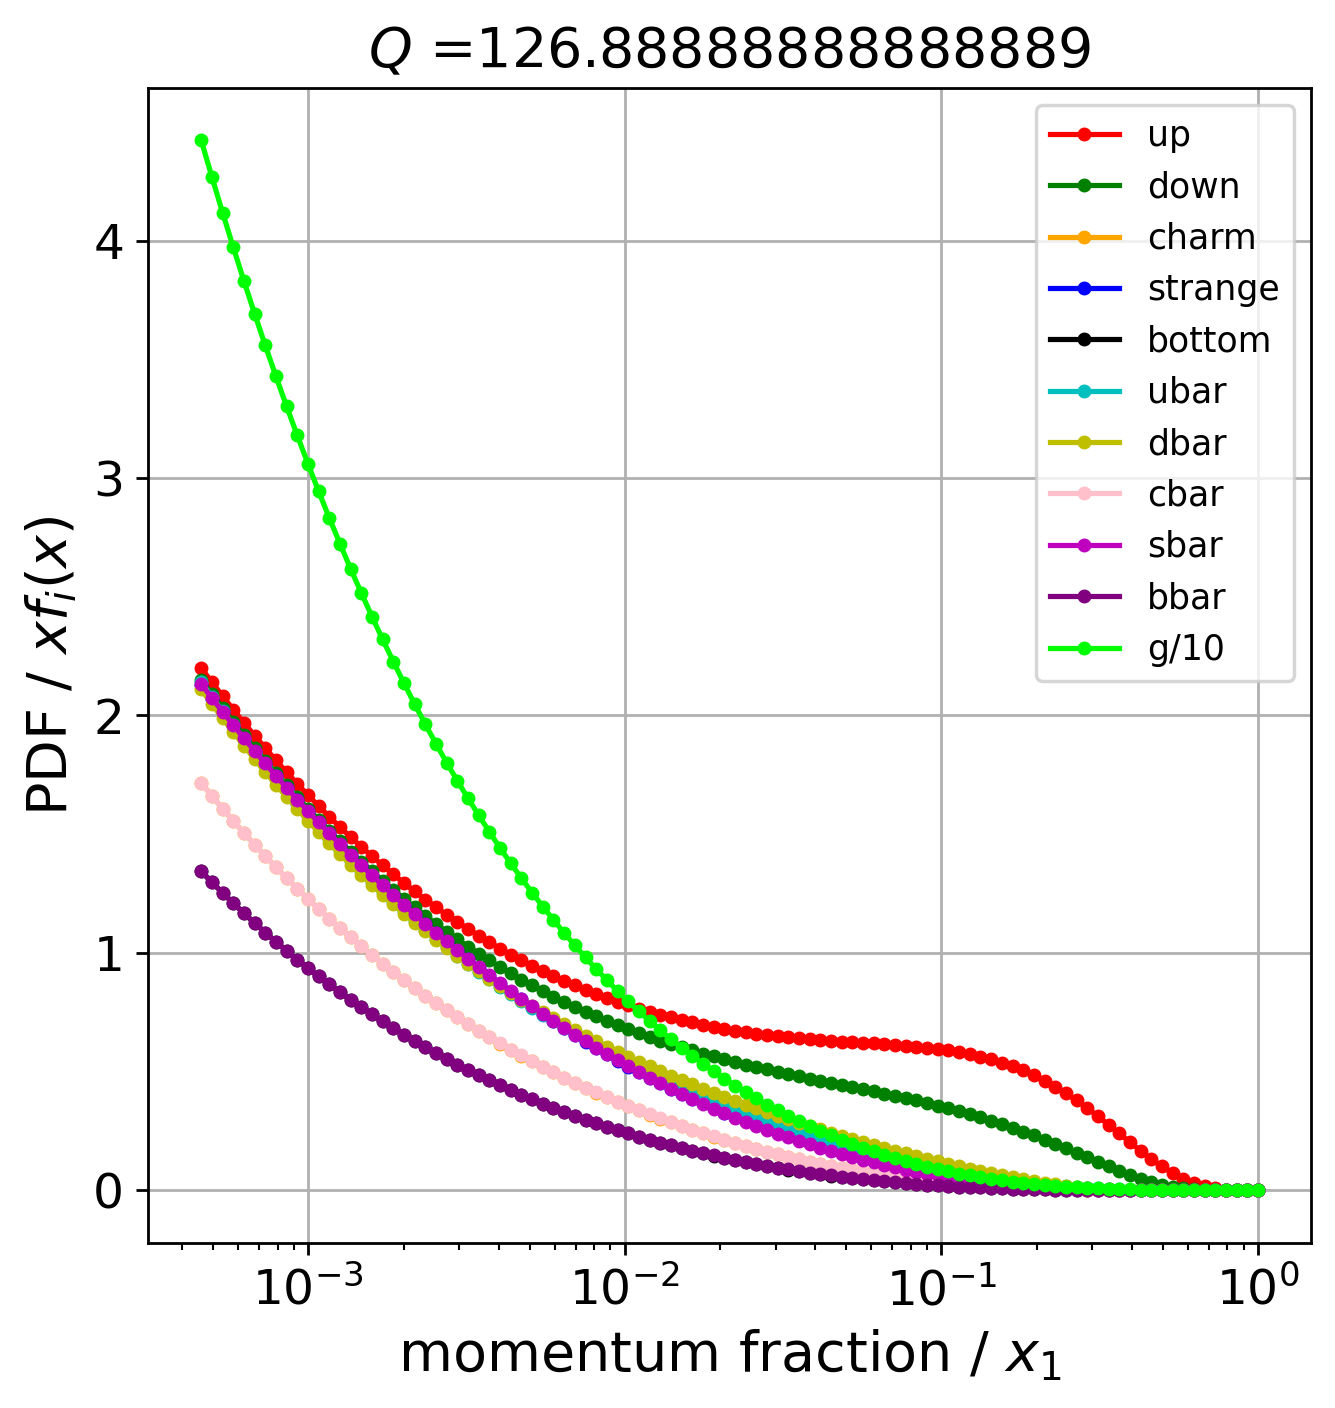

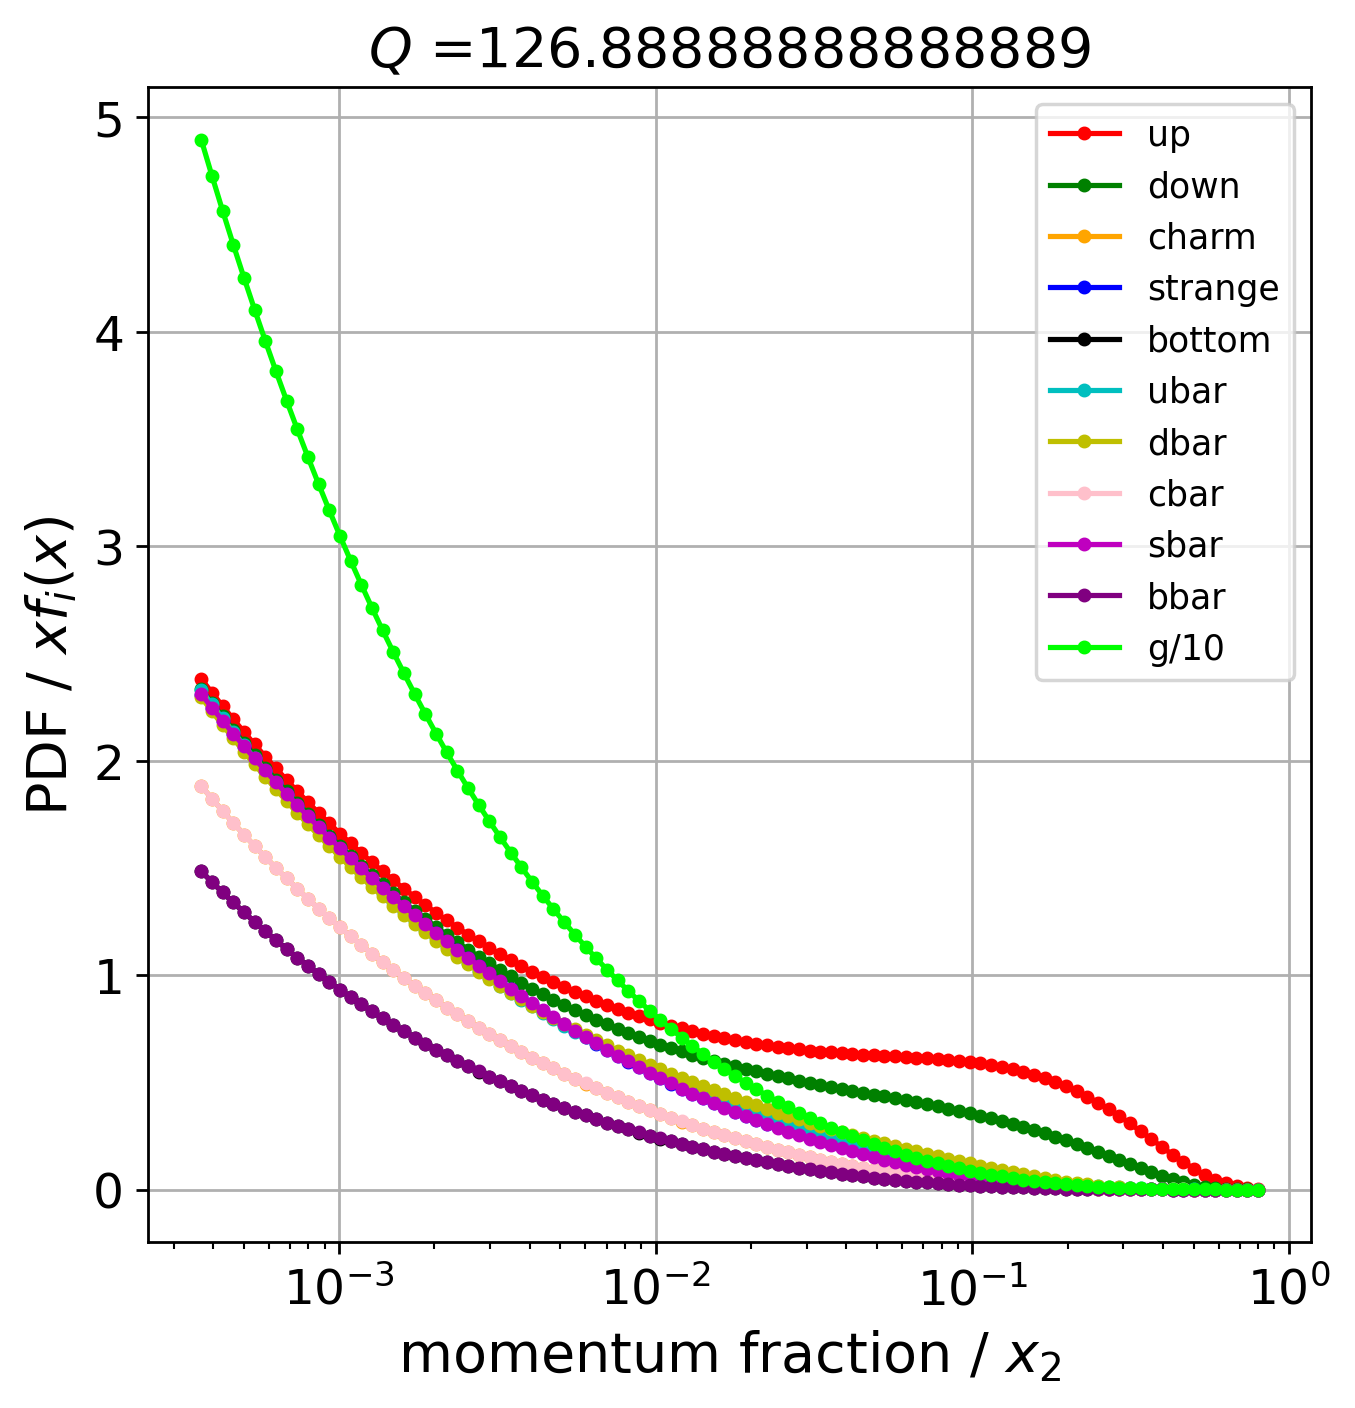

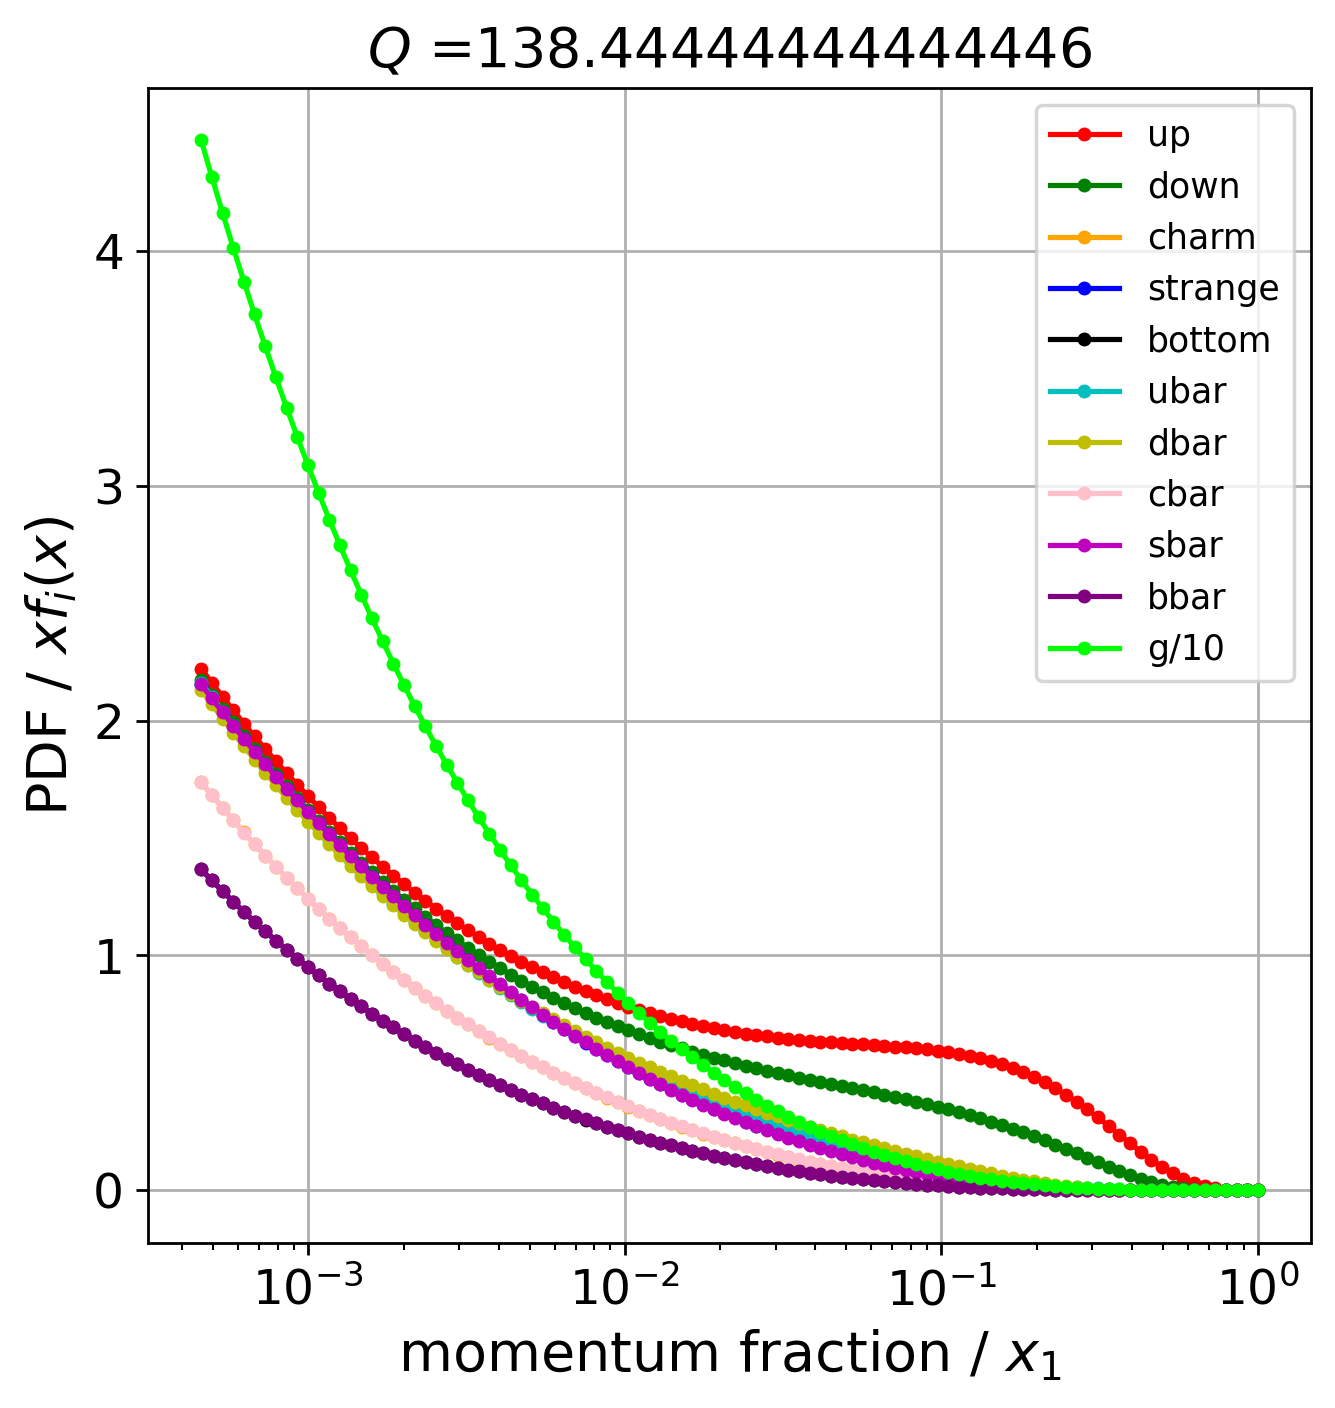

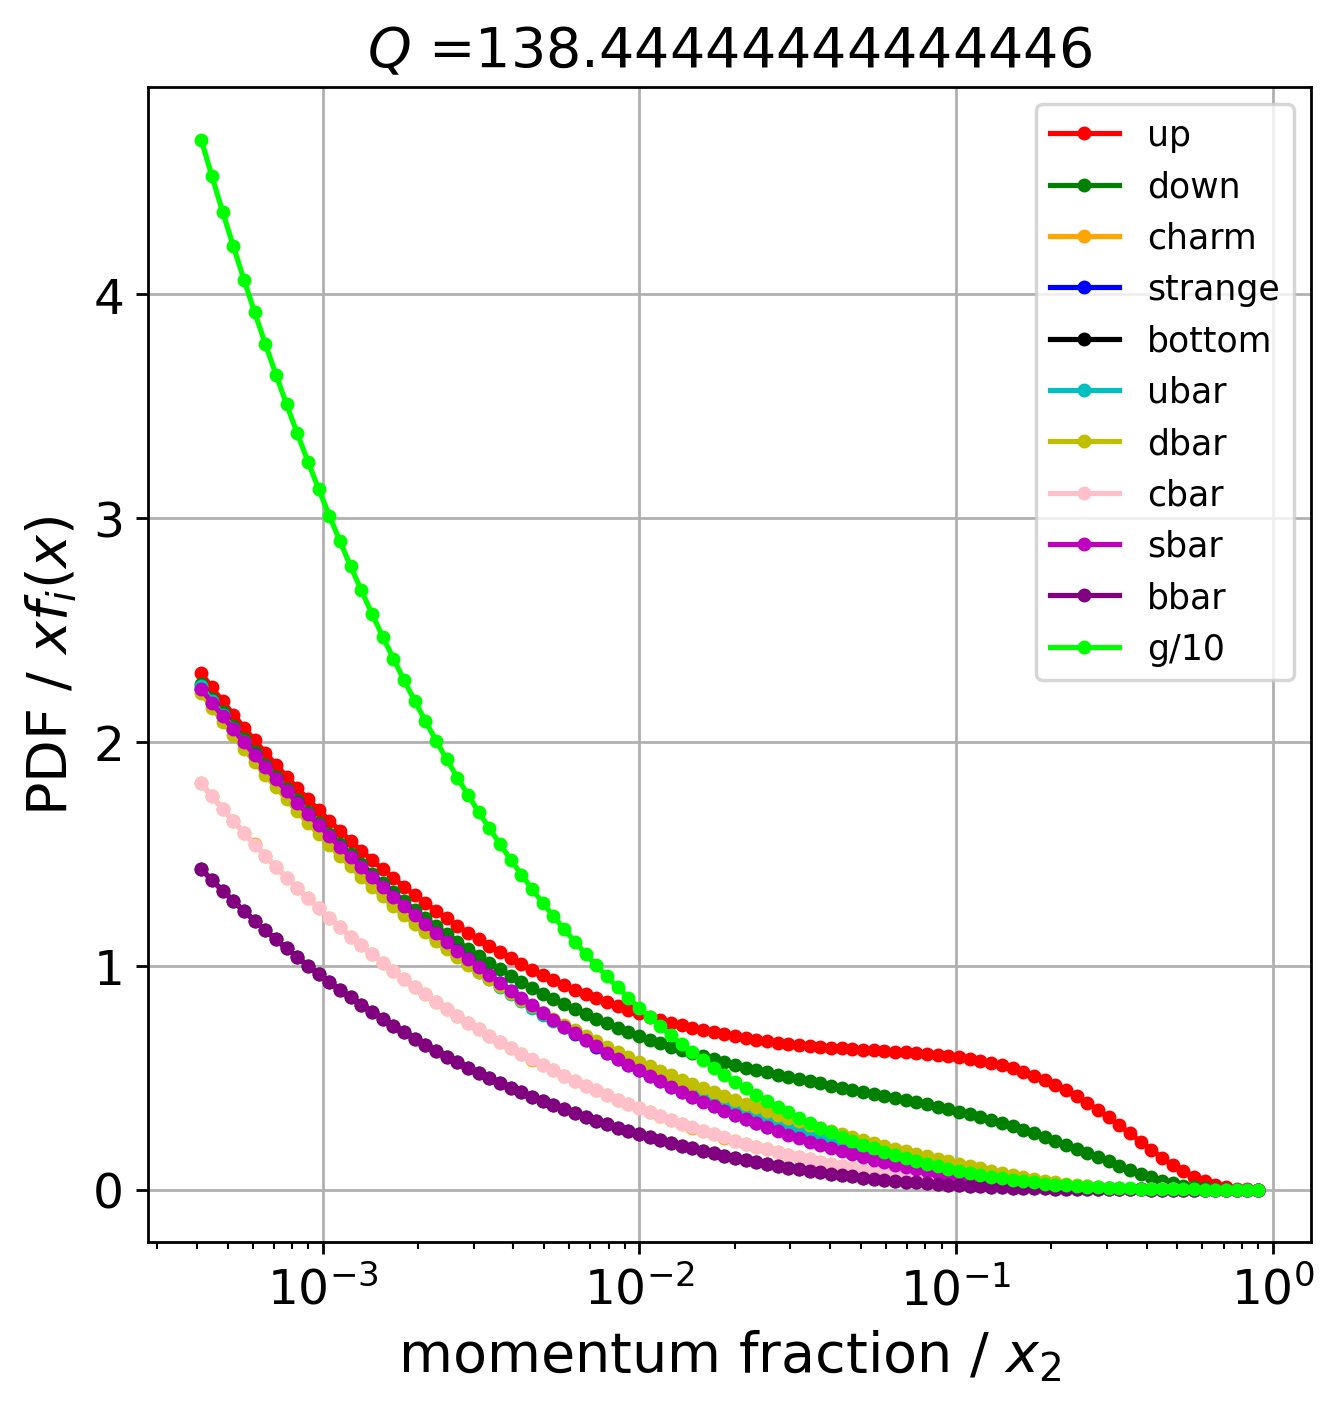

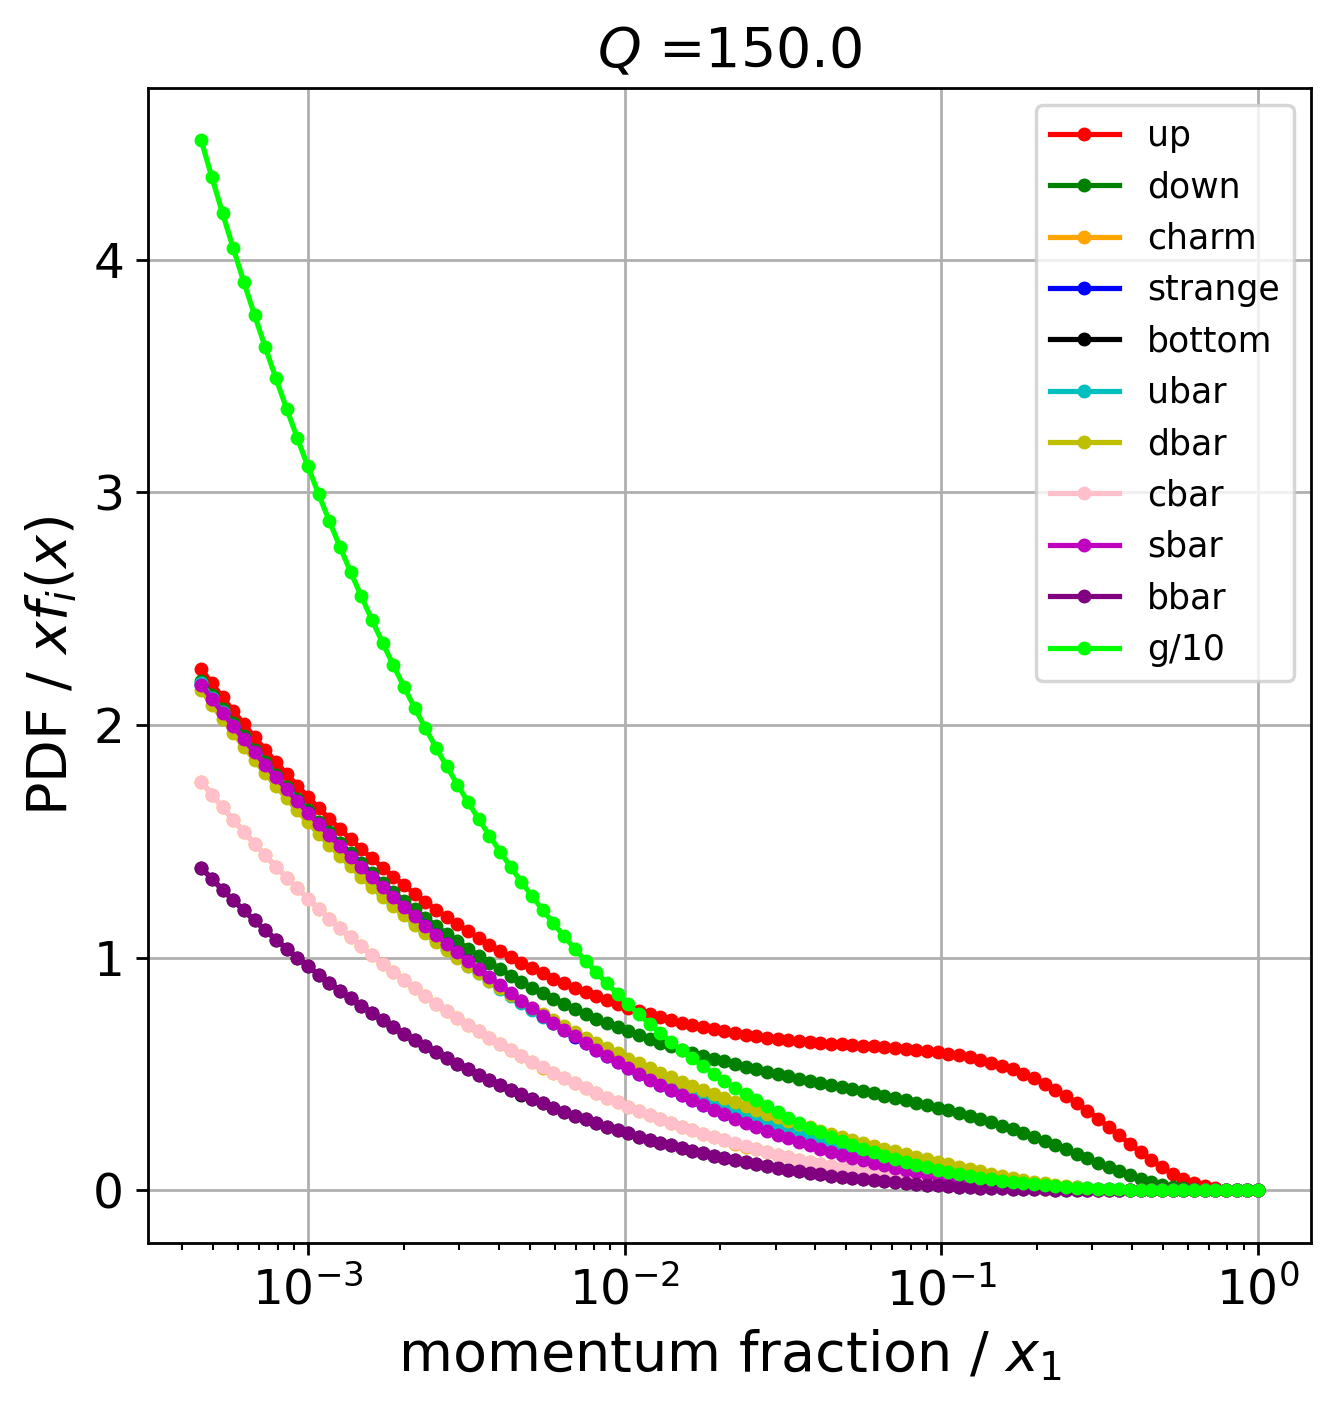

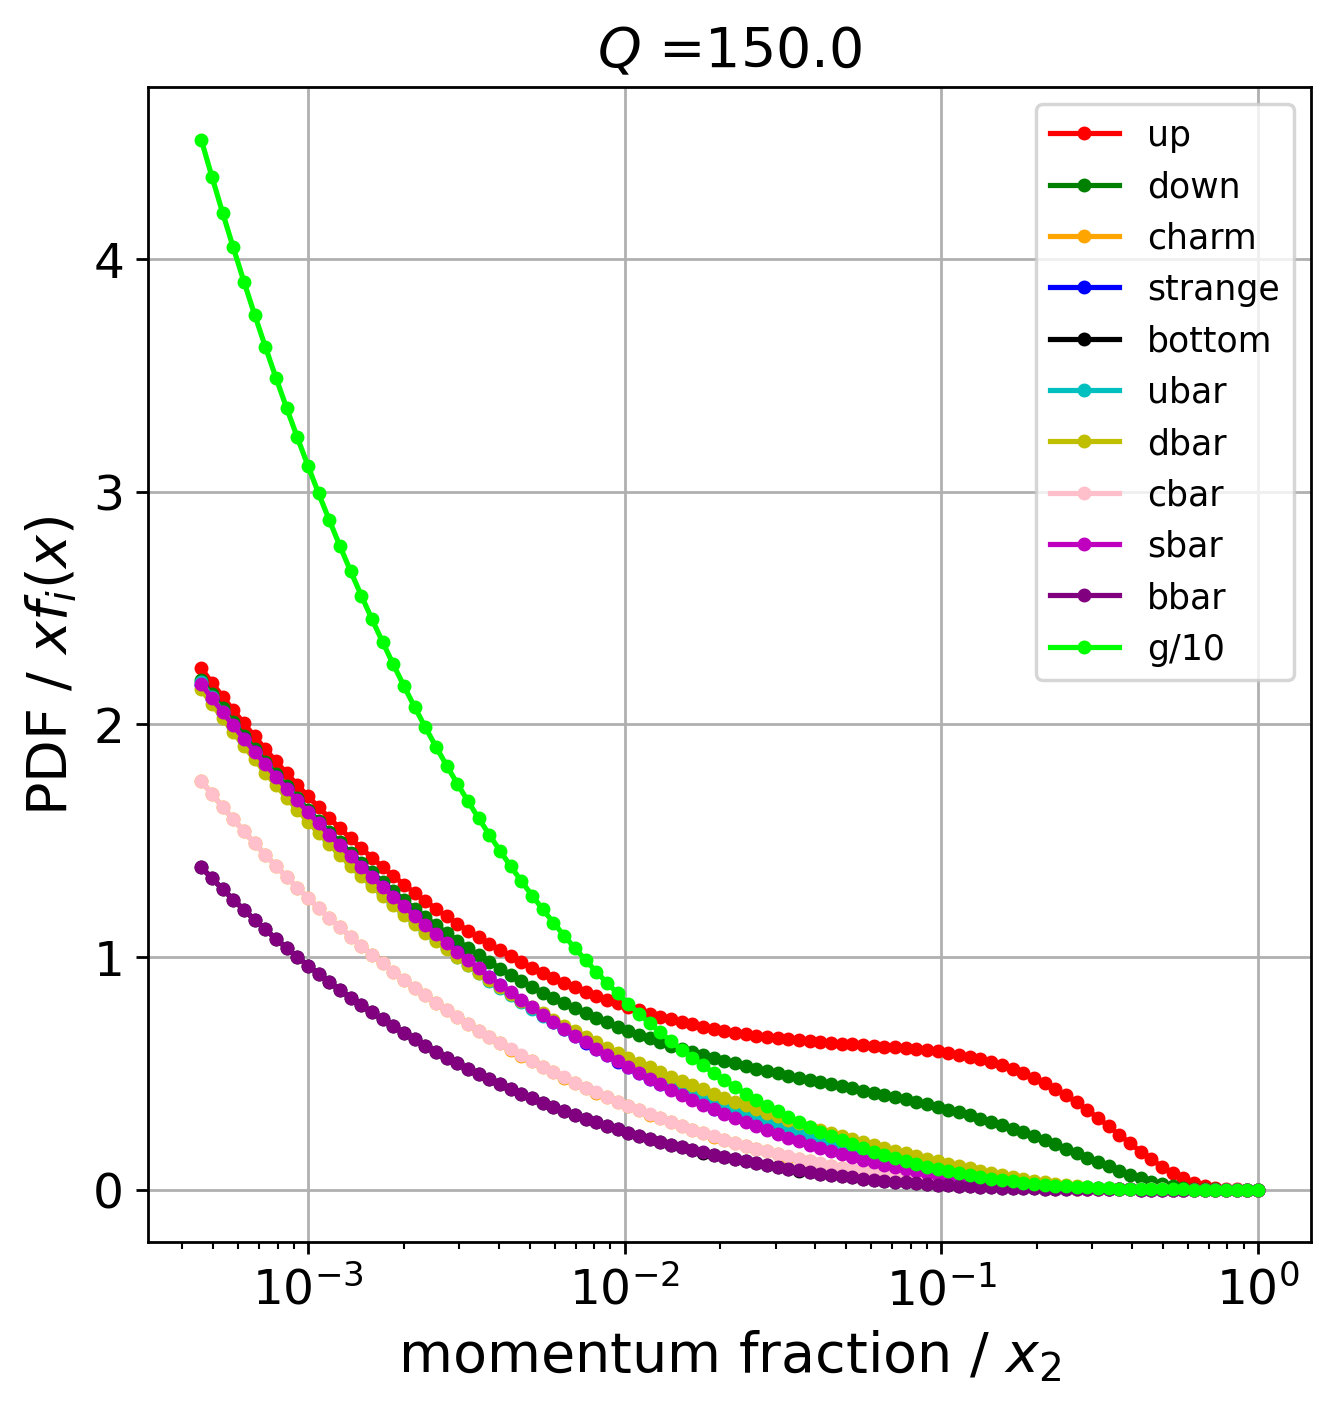

In [5]:
if __name__=='__main__':
    main()